matrix transformation only for perfect file (with path 0)

In [1]:
import pandas as pd
import numpy as np
import os, sys
import shutil
from itertools import islice
from itertools import repeat
from addict import Dict
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import math
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from chart_studio import plotly
from adjustText import adjust_text
# from chart_studio import pyplot as ply
# import plotly.plotly as py
import plotly.offline as pyoff
import re
import mplcursors
import mpldatacursor
import warnings
from varname import nameof

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# pymatgen libraries
from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations import SupercellTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.io.cif import CifWriter
from pymatgen.io.vasp.inputs import Poscar

# from get_weirdos_ver3_new_cleaned import Operation, Orientation, PreProcessingCONTCAR, ReadStructure, Mapping, Movement, Plot, CreateDataFrame
# splitall, copy_rename_single_file, copy_rename_files, check_folder_existance, weighing_movement
from positionism.functional import func_cartesian, func_directory, func_distance, func_kmeans, func_file
from positionism.preprocessing import create_dataframe, CONTCARorPOSCAR
from positionism.orientation import orient_propagate
from positionism.read import coordinate_and_el, metainfo
from positionism.mapping import flag_and_map, atom_indexing, labelling, output_CIF, output_weirdos
from positionism.plot import mapping_labelling, movement, structure_analysis
from positionism.movement import move_by_occupancy, move_by_tuple_cage, move_by_distance

direc = os.getcwd() # get current working directory

In [2]:
# modif_dx_dz_cif_allvariables_litype

# change_dx_dz_litype

In [3]:
poscar_line_nr_start = 8        # index from 0
poscar_line_nr_end = 60
latticeconstantsmatrix_line_nr_start = 2
cif_line_nr_start = 26          # index from 0

proceed_orientation="False"
proceed_XDATCAR = "False"

if proceed_XDATCAR == "True":
    proceed_NEB = "True" 
    type_movement = "xdatcar_temp"      # insert here
else:
    proceed_NEB = "True"
    type_movement = "intracage"       # insert here

amount_Li = 24
reference_Li_nr = 23    # moved Li is placed in nr 23
folder_name_init_system = "/Init_System"
results_folder = "_results"
if proceed_NEB == "True":
    calc_type = f"_neb/{type_movement}"
else:
    calc_type = "_mapping"

file_new_system = "CONTCAR"
file_init_system = "POSCAR"

col_excel_geo = "geometry"
col_excel_path = "path"
col_excel_toten = "toten [eV]"

amount_P = 4
amount_S = 20
amount_Cl = 4

lattice_constant = 10.2794980000

# litype = 0
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type0"

# litype = 1
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type1"

# litype = 2
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type1_area2" # "Li6PS5Cl_optitype1" # "Li6PS5Cl_type2" # same as: "Li6PS5Cl_type2_2iia_115_new"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype2" # "Li6PS5Cl_type2"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype1n2_strictr_a"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type2"

# litype = 3
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3" # use this
# # # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3_opti1"
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3_init"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype1n2_strictr_a_type3_B_noweirdnr" # "Li6PS5Cl_optitype1n2_strictr_a_type3" # "Li6PS5Cl_optitype1n2_strictr_a_type3_A"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3"

litype = 4
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_trial2"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_DBSCAN_0_5_a_optitype2"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_31" # "Li6PS5Cl_optitype1n2_strictr_a_type4_weirdo1_var2"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype1n2_strictr_a_type4_weirdo1_var2_opti_zoomedin"
file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4"

# litype = 5
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5"           # better
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial2_a"
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial2_b"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5"

# litype = 6
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_C_type6_b_type2"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type6_init_opti"

file_perfect_poscar_48n24 = f"{file_perfect_poscar_48n24_wo_cif}.cif"

activate_radius = 1 # [1: r1 for 24g 48htype1 48htype2, 2: r2 for 48htype1 48htype2, 3: r3 for 48htype2]
max_mapping_radius = 0.051 # 0.051 # 0.051 # 0.043 ### 0.018 # 0.015 # 0.043
max_mapping_radius_48htype2 = 0.066 # 0.076 ### 0.075 # 0.051 # 0.076
max_mapping_radius_48htype1_48htype2 = (max_mapping_radius + max_mapping_radius_48htype2) / 2
file_perfect_poscar_24 = "Li6PS5Cl_type0.cif"

file_name_toten = f".{folder_name_init_system}/toten_final.ods"

if activate_radius == 3:
    folder_name_destination_restructure = f"/{results_folder}/{calc_type}/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}/"
elif activate_radius == 2:
    folder_name_destination_restructure = f"/{results_folder}/{calc_type}/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}/"
elif activate_radius == 1:
    folder_name_destination_restructure = f"/{results_folder}/{calc_type}/restructure_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}/"
else:
    print("activate_radius is not correct")

# # # # # folder_name_destination_lattice_coeff_input = "/lattice_coeff_input/"
folder_name_perfect_poscar = "/_reference_cif/"
file_restructure = "CONTCAR"
file_restructure_positive = "CONTCAR_positive"
element_restructure = "P"

cif_columns = ['species', 'idx_species', 'unkownvar_1', 'coord_x', 'coord_y', 'coord_z', 'unkownvar_2']
poscar_columns_type2 = ['coord_x', 'coord_y', 'coord_z', 'species']
contcar_columns_type2 = ['coord_x', 'coord_y', 'coord_z']

var1 and var2 show that arc matters

var2 and var3 show that distance by 0.02ish angstrom in 24g-48h doesn't matter

var3 and var4 show that bigger radius by 0.007 reduce the weirdos each type by around 2

var5 same as var3

var5 and var6 show that bigger radius by 0.009 reduce the weirdos each type by around 4




04_important_outputs_var6 with radius 0.045 and 0.055 show no difference

In [4]:
direc_init_system = direc+str(folder_name_init_system)
# # direc_perfect_system = direc+os.sep+str(file_perfect_poscar_24)
direc_restructure_destination = direc+str(folder_name_destination_restructure)
# # # # # direc_lattice_coeff_input = direc+str(folder_name_destination_lattice_coeff_input)
direc_perfect_poscar = direc+str(folder_name_perfect_poscar)

path_perfect_poscar_24 = os.path.join(direc_perfect_poscar, file_perfect_poscar_24)
path_perfect_poscar_48n24 = os.path.join(direc_perfect_poscar, file_perfect_poscar_48n24)
# path_perfect_poscar_P = os.path.join(direc_perfect_poscar, file_perfect_poscar_P)

In [5]:
dtype = {col_excel_geo: float, col_excel_path: float}

data_toten = pd.read_excel(file_name_toten, dtype=dtype, engine="odf")
data_toten_ori = data_toten
data_toten = data_toten.sort_values(by=["geometry","path"],ignore_index=True,ascending=False)

In [6]:
df_mapping_init = create_dataframe.base(data_toten, file_new_system)

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/preprocessing/create_dataframe.py:113: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/preprocessing/create_dataframe.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/preprocessing/create_dataframe.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

### Delete all elements in CONTCAR except Phospor

#### Copy into new directory and rename files

In [7]:
# just refreshing folder
func_directory.check_folder_existance(direc_restructure_destination, empty_folder=True)

In [8]:
# just copy reference file
func_directory.copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)
func_directory.copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_48n24, prefix=None)

### Use get_translational_matrix
alternative to get_transformation() from pymatgen: find_primitive() from spglib

In [9]:
# # file_loc_mask_1, df_mapping_metainfo = propagate.calculate(file_loc, orientation=False)

# Now Processing with other folders that are with mask = 0 (not perfect system)

#### copy the data of scaling and translation to the file_loc as initial data

In [10]:
# df_mapping_metainfo = file_loc.copy()
func_directory.copy_rename_files(df_mapping_init, direc_restructure_destination, file_restructure, prefix=None, savedir = False)

In [11]:
### ADJUSTMENT HERE !!!
if proceed_NEB == "True":
    CONTCARorPOSCAR.edit_to_normal_elements(df_mapping_init, direc_restructure_destination, file_restructure, prefix = None)
else:
    pass

CONTCARorPOSCAR.positive_lessthan1(df_mapping_init, direc_restructure_destination, poscar_line_nr_start, poscar_line_nr_end, contcar_columns_type2, file_type = "CONTCAR", var_name_in = None, var_name_out = "positive", n_decimal=16)

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/preprocessing/CONTCARorPOSCAR.py:147: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/preprocessing/CONTCARorPOSCAR.py:147: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/preprocessing/CONTCARorPOSCAR.py:147: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [12]:
df_mapping_init.columns #####

Index(['geometry', 'path', 'subdir_new_system', 'g+p', 'g+p+1', 'g+p-1',
       'perfect_system', 'p_s_mask', 'toten [eV]', 'subdir_positive_CONTCAR'],
      dtype='object')

In [13]:
df_mapping_init_mask_1, df_mapping_metainfo = orient_propagate.calculate(df_mapping_init, direc_restructure_destination, file_restructure_positive, 
                                                                       path_perfect_poscar_24
                                                                       , proceed_orientation)

In [14]:
# # # just copy file
# # Operation.File.copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)

In [15]:
df_mapping_metainfo.head() #####

,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],subdir_positive_CONTCAR
0,0.0,8.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,0.0,7.0,NaN,0,-272.337269,/home/azka/Documents/01_Masterthesis/Atomic-Po...
1,0.0,7.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,7.0,8.0,6.0,NaN,0,-272.309259,/home/azka/Documents/01_Masterthesis/Atomic-Po...
2,0.0,6.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,6.0,7.0,5.0,NaN,0,-272.227022,/home/azka/Documents/01_Masterthesis/Atomic-Po...
3,0.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,5.0,6.0,4.0,NaN,0,-271.870564,/home/azka/Documents/01_Masterthesis/Atomic-Po...
4,0.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,4.0,5.0,3.0,NaN,0,-272.208118,/home/azka/Documents/01_Masterthesis/Atomic-Po...


#### Convert new cif file of orientated structure into only positive value

TO DO: add subdir for lattice constant into file_loc

In [16]:
# # # # # def copy_rename_files_subpaths_latticecoeff(file_loc, source_directory, direc_lattice_coeff_input, var_filename, index):
# # # # #     file_loc['subdir_lattice_coeff_input'] = None

# # # # #     filename_to_copy = f"{int(file_loc['geometry'][index])}_{int(file_loc['path'][index])}_POSCAR_{var_filename}"
# # # # #     source_path = os.path.join(source_directory, filename_to_copy)
    
# # # # #     subdir_lattice_coeff_input = direc_lattice_coeff_input + str(int(file_loc['geometry'][index])) +  "/" + str(int(file_loc['path'][index])) + "/"
# # # # #     new_filename = "POSCAR"
# # # # #     destination_path = os.path.join(subdir_lattice_coeff_input, new_filename)

# # # # #     # check existance and emptying it
# # # # #     Operation.File.check_folder_existance(subdir_lattice_coeff_input)
# # # # #     # Copy the file to the destination directory with the new name
# # # # #     shutil.copy2(source_path, destination_path)
# # # # #     print(f"File copied and renamed: {filename_to_copy} -> {destination_path}")

In [17]:
# # # # # var_filename = "trf_w_linalg_orientated_positive_lessthan1_diagonalizedconstants"

# # # # # for index in range(df_mapping_metainfo["geometry"].size):
# # # # #     copy_rename_files_subpaths_latticecoeff(df_mapping_metainfo, direc_restructure_destination, direc_lattice_coeff_input, var_filename, index)

#### Mapping to the closest neighbor

In [18]:
# from pymatgen.analysis.local_env import CrystalNN

# max_mapping_radius = 0.05282658993283027
# max_mapping_radius = 0.045
# max_mapping_radius = 0.055
# max_mapping_radius = 0.04197083906

ref_structure_48n24 = Structure.from_file(path_perfect_poscar_48n24)
cif_structure = Structure(ref_structure_48n24.lattice, ref_structure_48n24.species, ref_structure_48n24.frac_coords)
cif = CifWriter(cif_structure)
cif.write_file(f"{direc_restructure_destination}{file_perfect_poscar_48n24_wo_cif}_expanded.cif")


# Reverse df_mapping_metainfo for NEB

In [19]:
if proceed_NEB == "True":
    df_mapping_metainfo = df_mapping_metainfo[::-1].reset_index()
    df_mapping_metainfo = df_mapping_metainfo.drop('index', axis=1)

In [20]:
df_mapping_metainfo

,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],subdir_positive_CONTCAR
0,0.0,0.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,0.0,1.0,0.0,0.0,1,-272.239606,/home/azka/Documents/01_Masterthesis/Atomic-Po...
1,0.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,1.0,2.0,0.0,NaN,0,-272.258730,/home/azka/Documents/01_Masterthesis/Atomic-Po...
2,0.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,2.0,3.0,1.0,NaN,0,-272.408983,/home/azka/Documents/01_Masterthesis/Atomic-Po...
3,0.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,3.0,4.0,2.0,NaN,0,-272.260001,/home/azka/Documents/01_Masterthesis/Atomic-Po...
4,0.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,4.0,5.0,3.0,NaN,0,-272.208118,/home/azka/Documents/01_Masterthesis/Atomic-Po...
5,0.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,5.0,6.0,4.0,NaN,0,-271.870564,/home/azka/Documents/01_Masterthesis/Atomic-Po...
6,0.0,6.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,6.0,7.0,5.0,NaN,0,-272.227022,/home/azka/Documents/01_Masterthesis/Atomic-Po...
7,0.0,7.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,7.0,8.0,6.0,NaN,0,-272.309259,/home/azka/Documents/01_Masterthesis/Atomic-Po...
8,0.0,8.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,0.0,7.0,NaN,0,-272.337269,/home/azka/Documents/01_Masterthesis/Atomic-Po...


#### Filter only moving the Li-ions from 24g to 24g+48h

In [21]:
coor_ref_structure_48n24 = coordinate_and_el.single_structure(ref_structure_48n24)
coor_ref_structure_48n24_expanded = coordinate_and_el.single_structure(Structure.from_file(f"{direc_restructure_destination}{file_perfect_poscar_48n24_wo_cif}_expanded.cif"))


coordinate_and_el.structures(df_mapping_metainfo, mapping = "False")

if activate_radius == 3:
    flag_and_map.all_atoms_of_el(df_mapping_metainfo, coor_ref_structure_48n24, "Li", max_mapping_radius)
    flag_and_map.li_48htype1_48htype2(df_mapping_metainfo, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype1_48htype2)
    flag_and_map.li_48htypesmerged_level1(df_mapping_metainfo, "Li")
    flag_and_map.li_48htype2(df_mapping_metainfo, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    flag_and_map.li_48htypesmerged(df_mapping_metainfo, "Li", activate_radius)
elif activate_radius == 2:
    flag_and_map.all_atoms_of_el(df_mapping_metainfo, coor_ref_structure_48n24, "Li", max_mapping_radius)
    flag_and_map.li_48htype2(df_mapping_metainfo, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    flag_and_map.li_48htypesmerged(df_mapping_metainfo, "Li", activate_radius)
elif activate_radius == 1:
    flag_and_map.all_atoms_of_el(df_mapping_metainfo, coor_ref_structure_48n24, "Li", max_mapping_radius)

# flag_and_map.all_atoms_of_el(df_mapping_metainfo, coor_ref_structure_48n24, "P", max_mapping_radius)
# flag_and_map.all_atoms_of_el(df_mapping_metainfo, coor_ref_structure_48n24, "S", max_mapping_radius)
# flag_and_map.all_atoms_of_el(df_mapping_metainfo, coor_ref_structure_48n24, "Cl", max_mapping_radius)

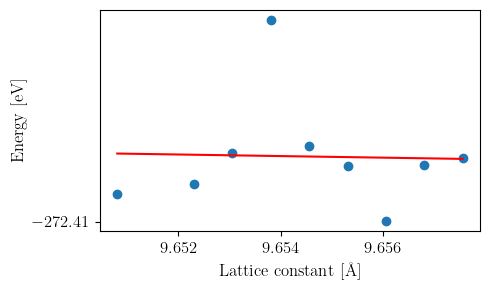

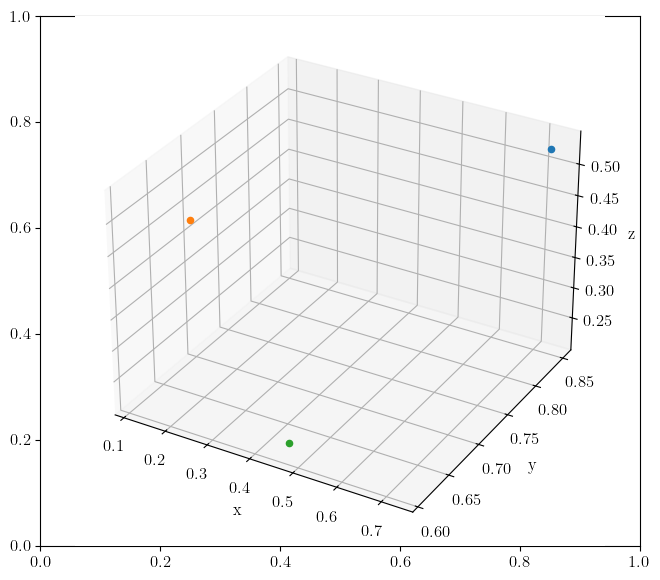

In [22]:
atom_indexing.weirdos_el(df_mapping_metainfo, "Li", activate_radius)

atom_indexing.correct_idx_and_order_mapped_el(df_mapping_metainfo, 
                                                 "Li", activate_radius)
# output_CIF.write_merged_structure(df_mapping_metainfo, direc_restructure_destination, 
#                                     amount_Li, amount_P, amount_S, 
#                                     var_savefilename = "mapLi")

labelling.weirdos_to_top_n_closestcoorref_el(df_mapping_metainfo, 
                                             coor_ref_structure_48n24, 
                                             "Li", litype)

output_CIF.write_merged_structure(df_mapping_metainfo, direc_restructure_destination, 
                                    amount_Li, amount_P, amount_S, activate_radius, 
                                    var_savefilename = "mapLi")

output_CIF.correct_Li_idx(df_mapping_metainfo, direc_restructure_destination, 
                                        amount_Li, amount_P, amount_S, amount_Cl, 
                                        var_savefilename_init = "mapLi", 
                                        var_savefilename_new = "mapLi_reindexed")

output_CIF.Edit.format_spacing_cif(df_mapping_metainfo, direc_restructure_destination, 
                                   var_savefilename_init = "mapLi_reindexed", 
                                   var_savefilename_new = "mapLi_reindexed")
# # # # Operation.File.delete_files(df_mapping_metainfo, direc_restructure_destination, file_name_w_format = "mapLi_reindexed.cif")

output_CIF.correct_Li_idx_weirdos_appended(df_mapping_metainfo, direc_restructure_destination, 
                                                         amount_Li, amount_P, amount_S, amount_Cl, 
                                                         activate_radius,var_savefilename_init = "mapLi", 
                                                         var_savefilename_new = "mapLi_reindexed_weirdos_appended")

output_CIF.Edit.format_spacing_cif(df_mapping_metainfo, direc_restructure_destination, 
                                   var_savefilename_init = "mapLi_reindexed_weirdos_appended", 
                                   var_savefilename_new = "mapLi_reindexed_weirdos_appended")
# # # Operation.File.delete_files(df_mapping_metainfo, direc_restructure_destination, file_name_w_format = "mapLi_reindexed_weirdos_appended.cif")

output_CIF.ascending_Li(df_mapping_metainfo, direc_restructure_destination, 
                        var_filename_init = "mapLi_reindexed_weirdos_appended", 
                        var_savefilename_new = "mapLi_reindexed_weirdos_appended_reordered")
# # # Mapping.OutputCIF.format_spacing_cif(df_mapping_metainfo, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed_weirdos_appended_reordered", var_savefilename_new = "mapLi_reindexed_weirdos_appended_reordered")

atom_indexing.get_idx_coor_limapped_weirdos_dict(df_mapping_metainfo, coor_ref_structure_48n24, 
                                                 activate_radius, litype, el="Li")

labelling.get_label_mapping(df_mapping_metainfo, coor_ref_structure_48n24, 
                            "Li", activate_radius, litype)
# NECESSARY STEP 
labelling.relabel_48htype1(df_mapping_metainfo, litype, el="Li")

coor_weirdos_Li = output_weirdos.as_array(df_mapping_metainfo, activate_radius)

output_weirdos.create_POSCAR(coor_weirdos_Li, direc_restructure_destination, 
                                     lattice_constant, 
                                     filename = "POSCAR_weirdos")

CONTCARorPOSCAR.convert_to_cif_pymatgen(df_mapping_metainfo, direc_restructure_destination, 
                                        file_restructure = "CONTCAR_positive", 
                                        var_name = "CONTCAR_positive_pymatgen")

CONTCARorPOSCAR.get_latticeconstant_dict(df_mapping_metainfo, direc_restructure_destination, 
                                         proceed_XDATCAR, 
                                         var_filename = "CONTCAR")

structure_analysis.energy_vs_latticeconstant(df_mapping_metainfo, direc_restructure_destination,
                                             litype, var_filename = "CONTCAR", interpolate = True)

structure_analysis.weirdos_directcoor(df_mapping_metainfo, direc_restructure_destination, 
                                      activate_radius, litype)

get_dx_dz_init_litype(litype)


create_file_name_allvariables_litype

/home/azka/anaconda3/envs/positionism/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



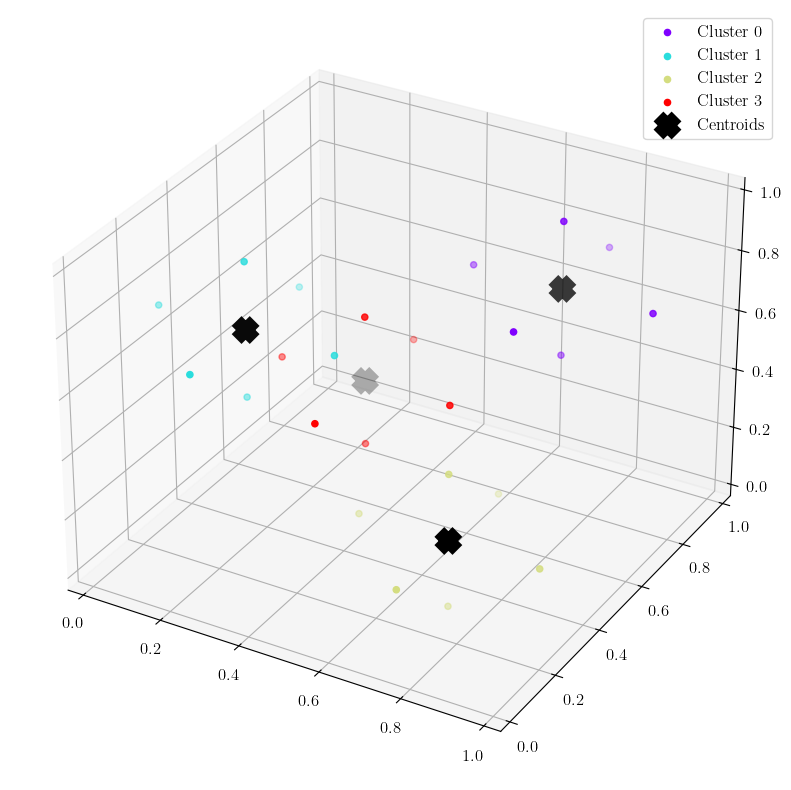

In [23]:
tuple_metainfo = metainfo.tuple(coor_ref_structure_48n24_expanded, litype, el = "Li")
# # NECESSARY STEP: modify "48htype1" in "idx_coor_limapped_weirdos_dict" for litype=1
metainfo.relabel_48htype1(tuple_metainfo, litype)

coor_48htype2_metainfo = metainfo.coor_48htype2(coor_ref_structure_48n24_expanded, litype, el = 'Li')

idx_coor_cage_order = {0: np.array([0.97111, 0.25   , 0.25   ]), 3: np.array([0.02889, 0.75   , 0.25   ]),
                       1: np.array([0.02889, 0.25   , 0.75   ]), 2: np.array([0.97111, 0.75   , 0.75   ])}

coor_24g_array = np.array([item['coor'] for sublist in tuple_metainfo.values() for item in sublist if item['type'] == '24g'])
centroids, labels = func_kmeans.kmeans_cluster_atoms(coor_24g_array, amount_clusters = 4)
func_kmeans.create_POSCAR_atoms_centroids_appended(coor_24g_array, centroids, direc_restructure_destination, lattice_constant, filename = "POSCAR_24g_centroids4")

idx_cage_coor_24g = metainfo.idx_cage_coor_24g(coor_24g_array, labels, idx_coor_cage_order, amount_clusters = 4)
tuple_cage_metainfo = metainfo.tuple_cage(tuple_metainfo, idx_cage_coor_24g)

In [24]:
# NECESSARY STEP: modify "48htype1" in "idx_coor_limapped_weirdos_dict" for litype=1
move_by_occupancy.relabel_48htype1(df_mapping_metainfo, litype)

df_mapping_metainfo_sorted = df_mapping_metainfo.sort_values("toten [eV]", ascending=True).reset_index()

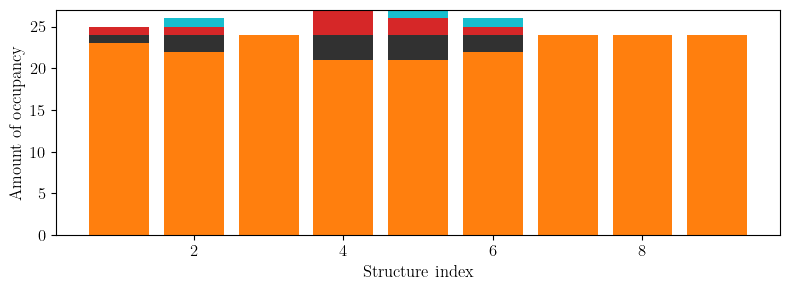

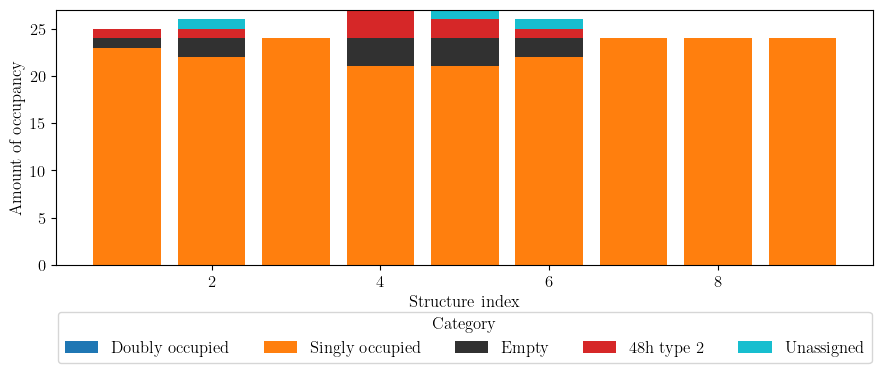

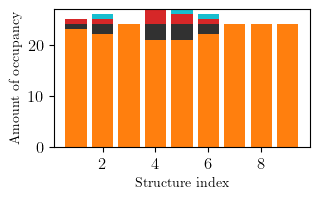

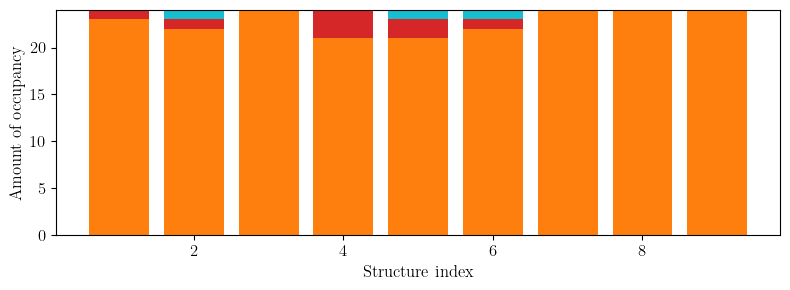

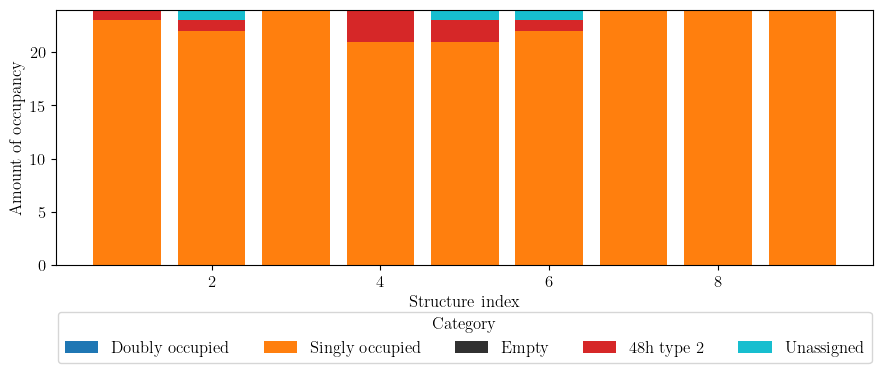

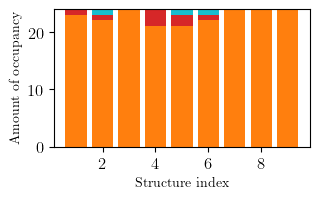

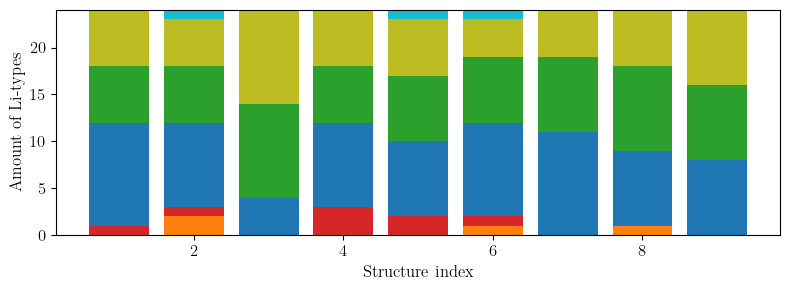

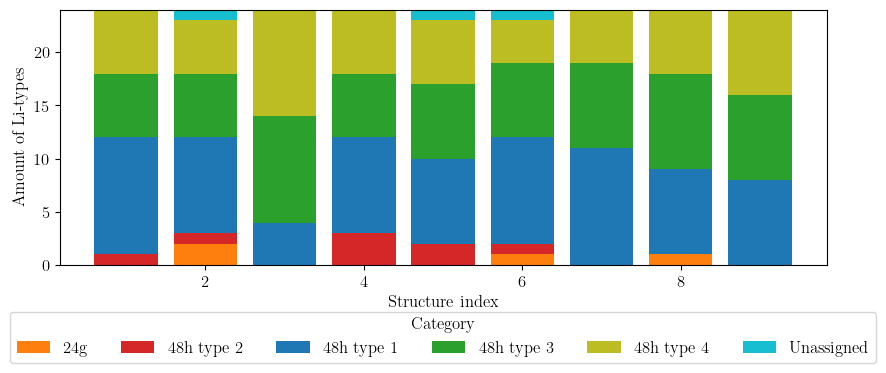

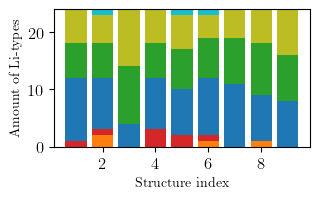

idx_file    45
48htype1     8
48htype2    78
48htype3    67
48htype4    56
24g          4
weirdo       3
dtype: object


In [25]:
dataframe = df_mapping_metainfo
sorted = "False"

move_by_occupancy.get_occupancy(dataframe, coor_ref_structure_48n24_expanded, tuple_cage_metainfo, el = "Li")
df_occupancy_strict = movement.plot_occupancy(dataframe, sorted, direc_restructure_destination, litype, activate_shiftby1_idxfile=True, strict_count=True)
df_occupancy = movement.plot_occupancy(dataframe, sorted, direc_restructure_destination, litype, activate_shiftby1_idxfile=True, strict_count=False)

move_by_tuple_cage.get_complete_closest_tuple_cage(dataframe, tuple_cage_metainfo, coor_48htype2_metainfo)
# weighing_movement(dataframe, litype)
# df_weighted = tuple_cage.get_df_movement(dataframe, to_plot = 'weight')
# # Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, Li_idxs="all")
# Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=False, Li_idxs='all')

labelling.get_amount_type(dataframe, litype, el = "Li")
# df_amount_type = mapping_labelling.plot_amount_type(dataframe, litype, el, style, category_labels)
df_amount_type = mapping_labelling.get_df_amount_type(dataframe, litype, el = "Li")
mapping_labelling.plot_amount_type(df_amount_type, sorted, direc_restructure_destination, litype, activate_shiftby1_idxfile=True, style = "bar")
print(df_amount_type.sum())

In [26]:
if proceed_NEB == "True":
    pass
else:
    dataframe = df_mapping_metainfo_sorted
    sorted = "True"

    move_by_occupancy.get_occupancy(dataframe, coor_ref_structure_48n24_expanded, tuple_cage_metainfo, el = "Li")
    df_occupancy_strict_sorted = movement.plot_occupancy(dataframe, sorted, direc_restructure_destination, litype, activate_shiftby1_idxfile=True, strict_count=True)
    df_occupancy_sorted = movement.plot_occupancy(dataframe, sorted, direc_restructure_destination, litype, activate_shiftby1_idxfile=True, strict_count=False)

    move_by_tuple_cage.get_complete_closest_tuple_cage(dataframe, tuple_cage_metainfo, coor_48htype2_metainfo)
    # weighing_movement(df_mapping_metainfo, litype)
    # df_weighted = tuple_cage.get_df_movement(df_mapping_metainfo, to_plot = 'weight')
    # # Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, Li_idxs="all")
    # Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=False, Li_idxs='all')

    labelling.get_amount_type(dataframe, litype, el = "Li")
    df_amount_type_sorted = mapping_labelling.get_df_amount_type(dataframe, litype, el = "Li")
    mapping_labelling.plot_amount_type(df_amount_type_sorted, sorted, direc_restructure_destination, litype, activate_shiftby1_idxfile=True, style = "bar")
    print(df_amount_type_sorted.sum())

In [27]:
# chunk_size = 3
# total_items = amount_Li  # Adjust this if your total number of items changes

# # Loop through the range in steps of chunk_size
# for start_idx in range(0, total_items, chunk_size):
#     end_idx = start_idx + chunk_size
#     Li_idxs_range = range(start_idx, end_idx)
    
#     # Call your function with the current range of Li_idxs
#     Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, activate_shifting_x = False, activate_diameter_line = False, Li_idxs = Li_idxs_range)

idx_coor24li_tuple_cage_belongin_complete_id48htype2

In [28]:
# # Function to count changes in each row
# def count_type_changes(row):
#     changes = 0
#     for i in range(len(row) - 1):
#         if row[i].startswith('48htype') and row[i + 1].startswith('48htype') and row[i] != row[i + 1]:
#             changes += 1
#     return changes

# # Apply the function to each row and create a new column with the counts
# df_type['changes_count'] = df_type.apply(count_48htype_changes, axis=1)


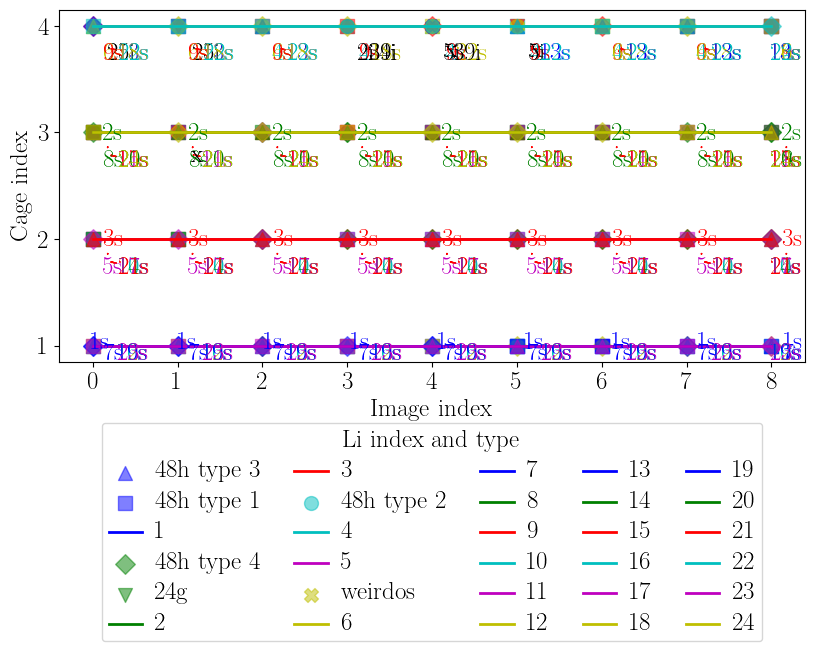

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/movement/move_by_tuple_cage.py:398: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/movement/move_by_tuple_cage.py:398: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/movement/move_by_tuple_cage.py:398: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/positionism/movement/move_by_tuple_cage.py:398: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/azka/Documents/01_Masterthesis/Atomic-

In [29]:
if proceed_NEB == "True":
    df_type = move_by_tuple_cage.get_df_movement(df_mapping_metainfo, to_plot = 'type', activate_closest_tuple = False)
    df_idx_tuple = move_by_tuple_cage.get_df_movement(df_mapping_metainfo, to_plot = 'idx_tuple', activate_closest_tuple = False)
    df_idx_cage = move_by_tuple_cage.get_df_movement(df_mapping_metainfo, to_plot = 'idx_cage', activate_closest_tuple = False)

    # # Plot.Movement.Distance.plot_distance(df_idx_cage, max_mapping_radius, Li_idxs="all")
    movement.plot_cage_tuple_label(df_idx_cage, df_type, df_idx_tuple, direc_restructure_destination, 
                                   max_mapping_radius, litype, activate_shiftby1=True, 
                                   activate_diameter_line=False, activate_relabel_s_i = True, Li_idxs="all")

    move_by_tuple_cage.count_occupancy_cage(df_idx_cage, direc_restructure_destination)

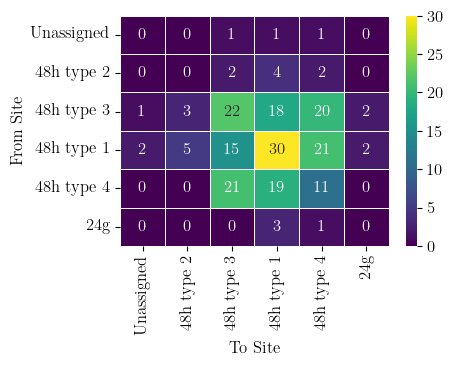

In [30]:
if proceed_NEB == "True":
    movement.get_and_plot_transition_matrix_relabeled(df_type, direc_restructure_destination, litype)

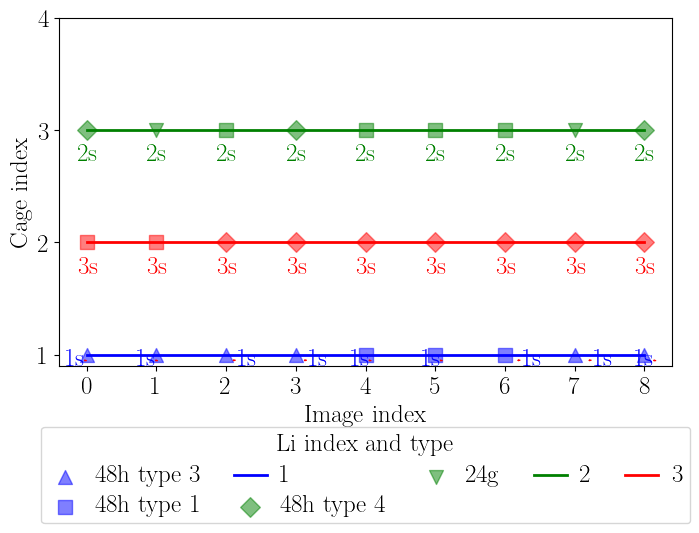

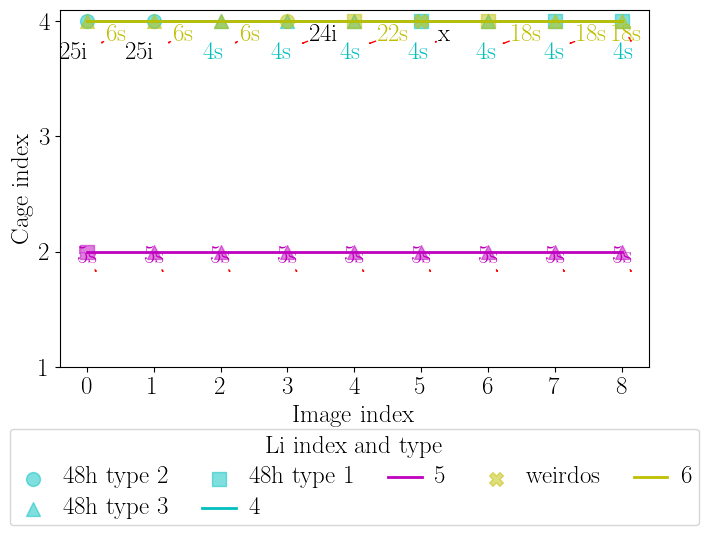

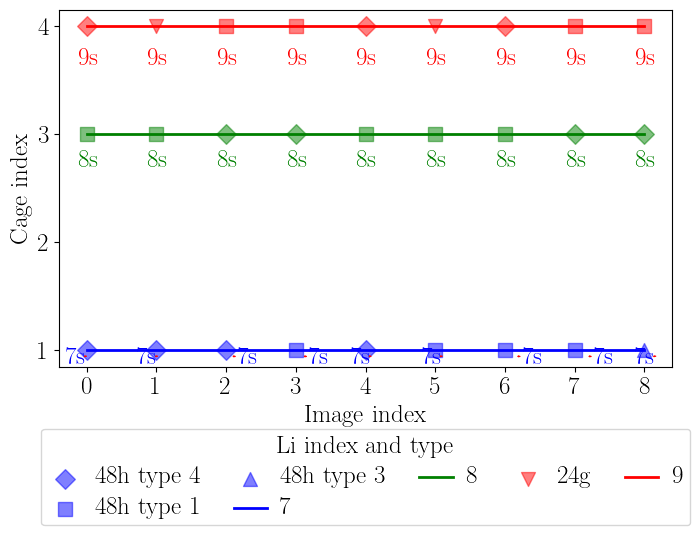

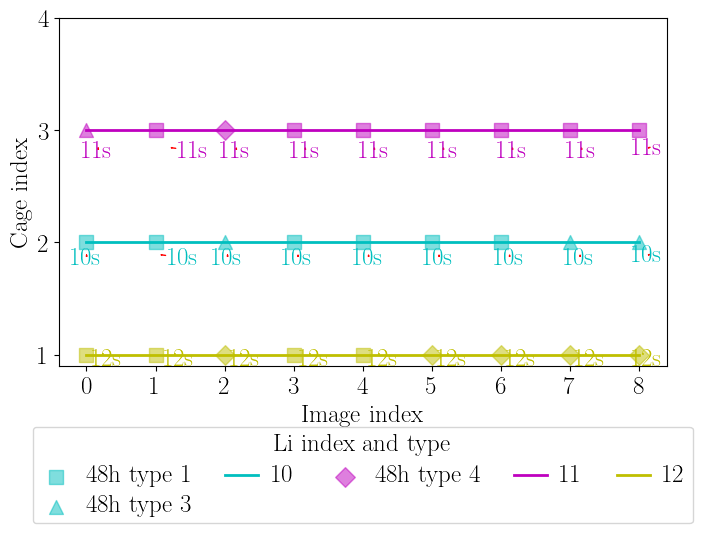

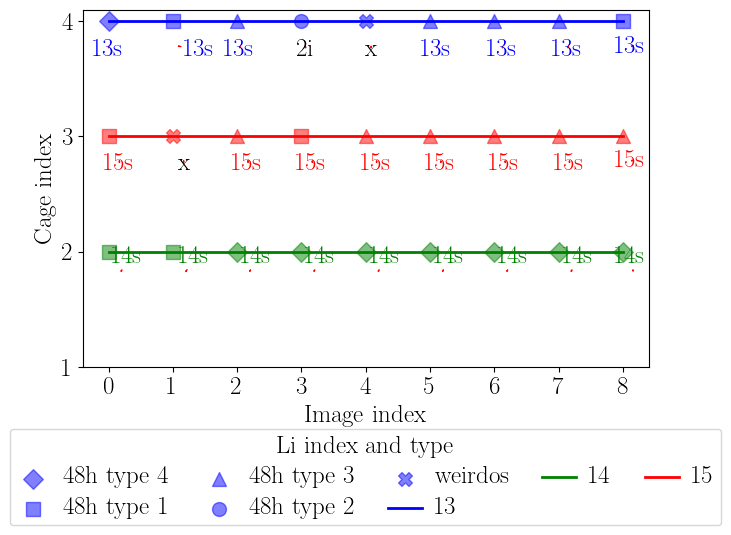

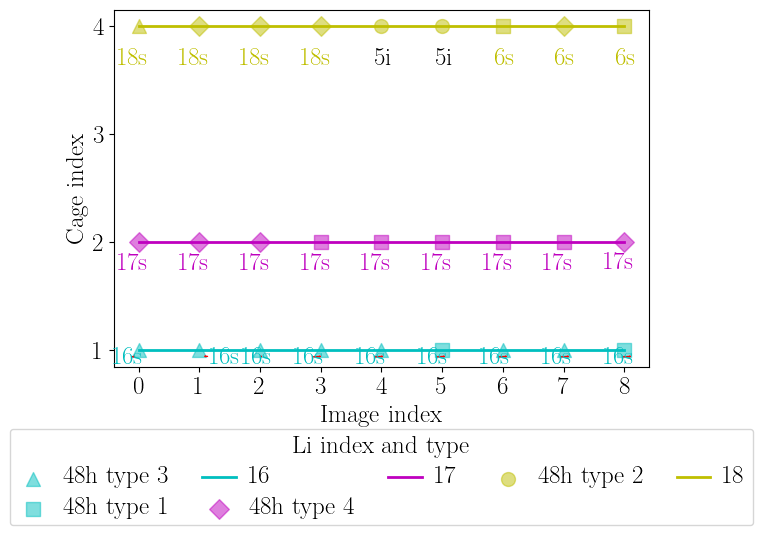

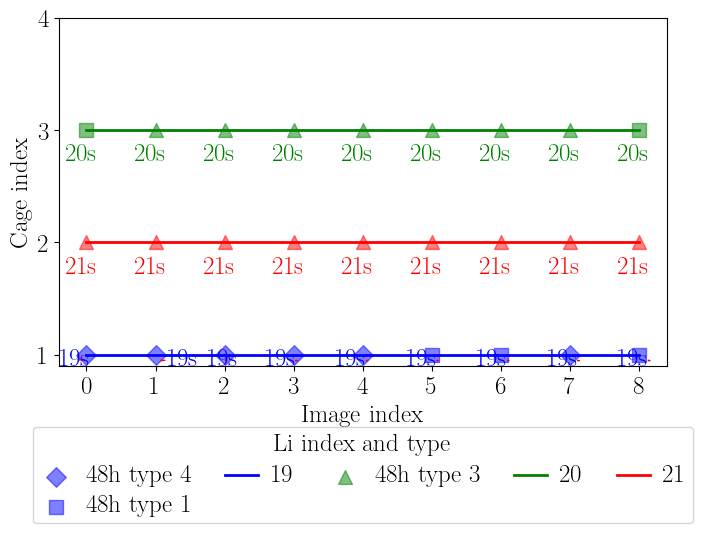

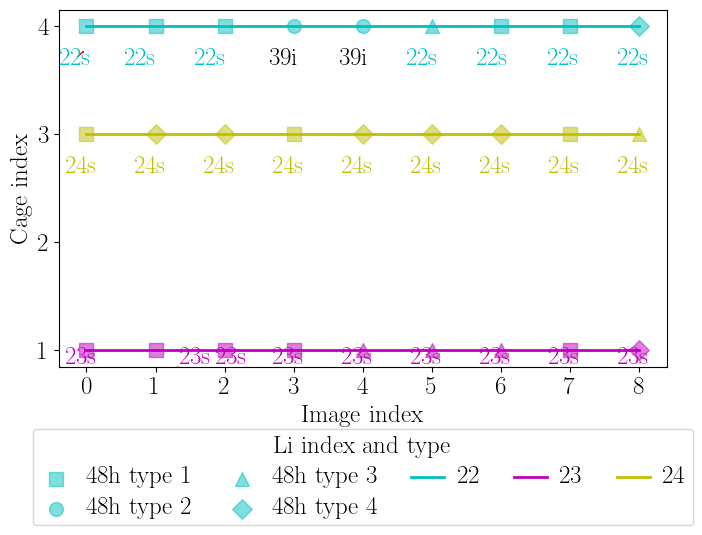

In [31]:
if proceed_NEB == "True":
    chunk_size = 3
    total_items = amount_Li  # Adjust this if your total number of items changes

    # Loop through the range in steps of chunk_size
    for start_idx in range(0, total_items, chunk_size):
        end_idx = start_idx + chunk_size
        Li_idxs_range = range(start_idx, end_idx)
        
        # Call your function with the current range of Li_idxs
        movement.plot_cage_tuple_label(df_idx_cage, df_type, df_idx_tuple, direc_restructure_destination, max_mapping_radius, litype, activate_shiftby1=True, activate_diameter_line=False, activate_relabel_s_i=True, Li_idxs=Li_idxs_range)

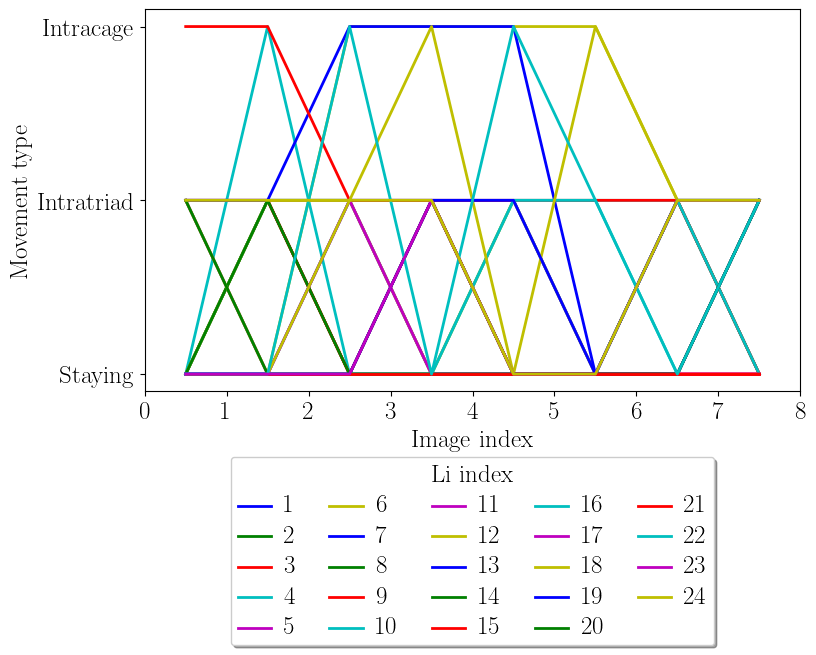

In [32]:
if proceed_NEB == "True":
    df_movement = move_by_tuple_cage.get_df_movement_category(df_mapping_metainfo, activate_closest_tuple=False)
    movement.plot_distance(df_movement, direc_restructure_destination, max_mapping_radius, litype, 
                           activate_shiftby1_labelatom=True, activate_shifting_x = True, 
                           activate_diameter_line = False, Li_idxs = 'all',
                           counted_object="movement")

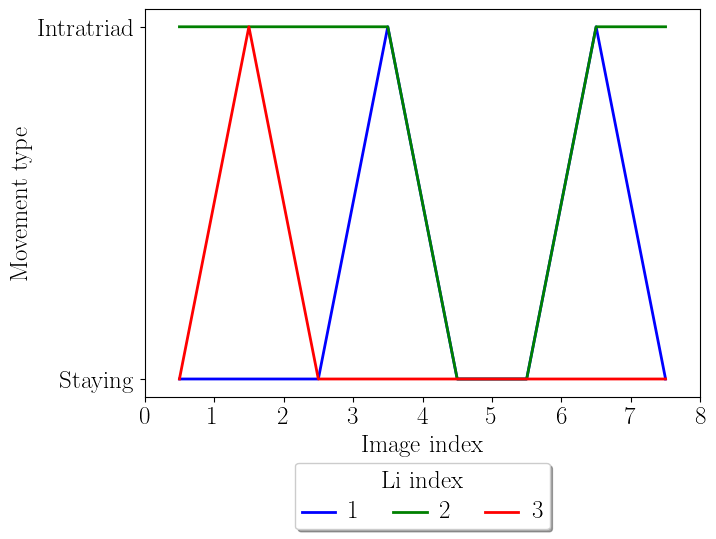

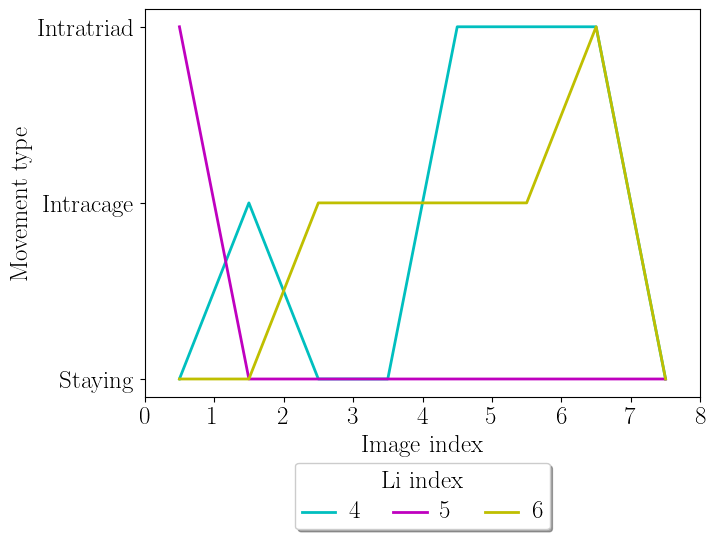

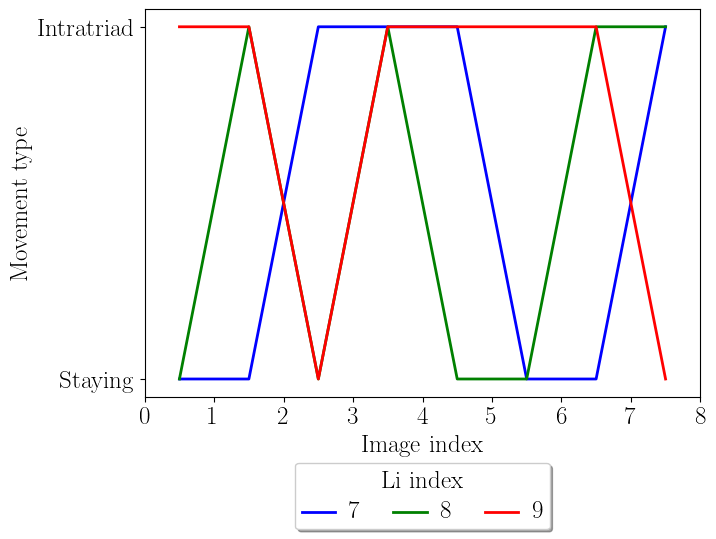

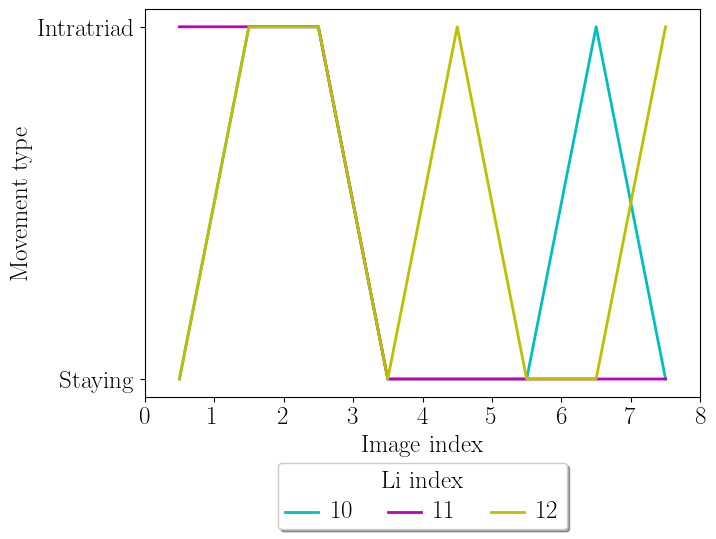

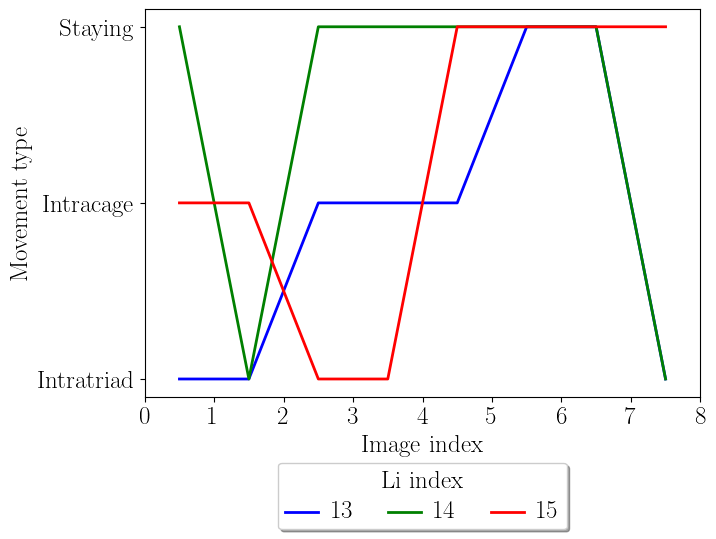

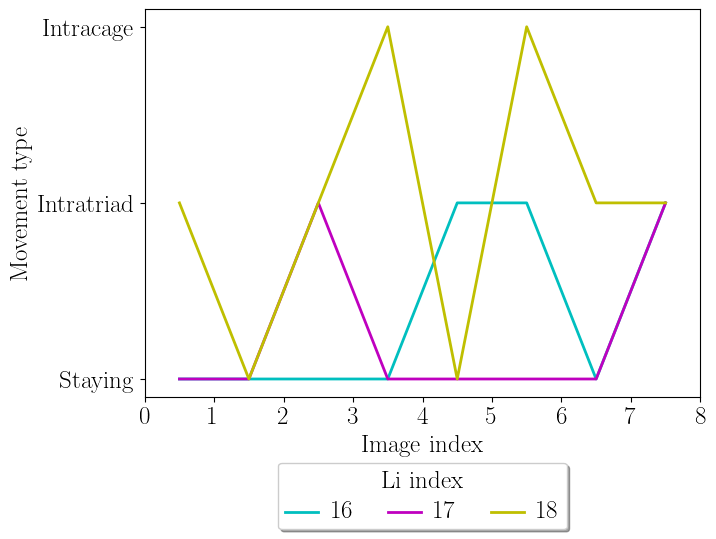

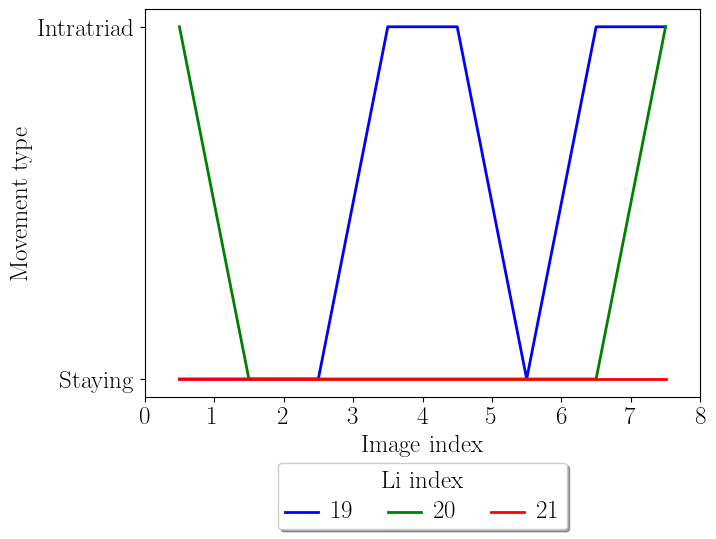

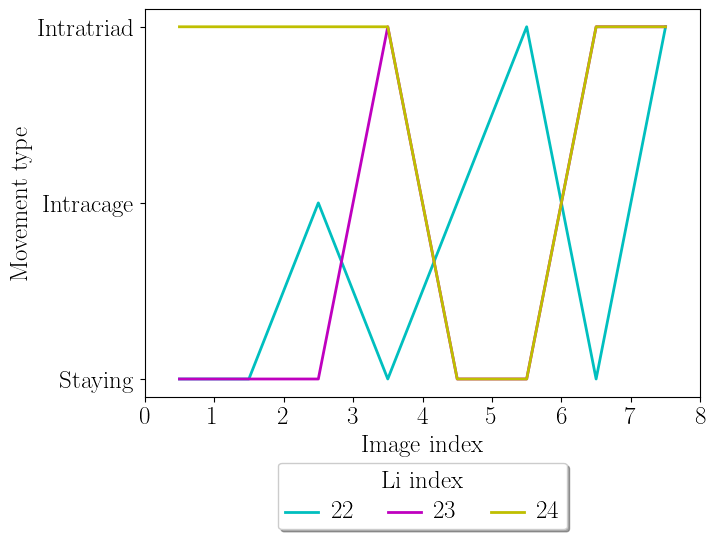

In [33]:
if proceed_NEB == "True":
    chunk_size = 3
    total_items = amount_Li  # Adjust this if your total number of items changes

    # Loop through the range in steps of chunk_size
    for start_idx in range(0, total_items, chunk_size):
        end_idx = start_idx + chunk_size
        Li_idxs_range = range(start_idx, end_idx)
        
        # Call your function with the current range of Li_idxs
        movement.plot_distance(df_movement, direc_restructure_destination, max_mapping_radius, litype, 
                               activate_shiftby1_labelatom=True, activate_shifting_x = True, 
                               activate_diameter_line = False, Li_idxs = Li_idxs_range,
                               counted_object="movement")

In [34]:
# # labelling.get_amount_type(df_mapping_metainfo_sorted, litype, el = "Li")

# # df = mapping_labelling.plot_amount_type(df_mapping_metainfo_sorted, litype, el, style, category_labels)

weirdo exists at file nr.:
16 =
17 =

48htype2 exists at:
17 =
20 =

idx_file       28
InTERcage       0
Intracage      14
Intratriad     71
Staying       107
dtype: object


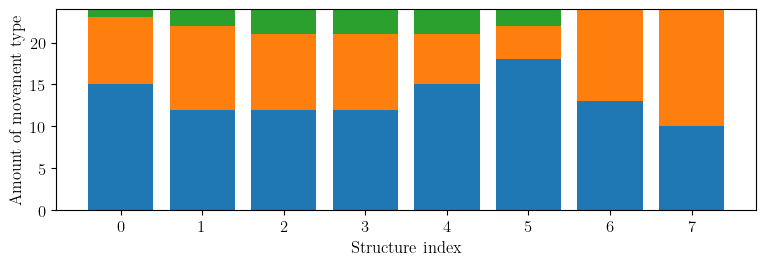

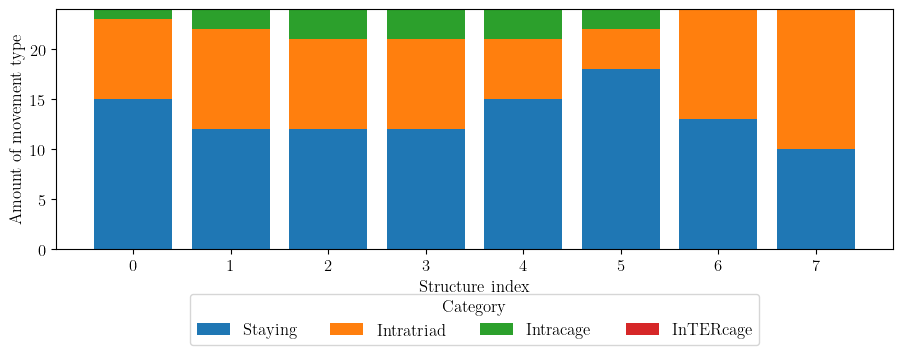

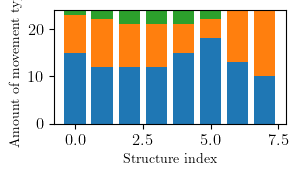

In [35]:
if proceed_NEB == "True":
    df_amount_movement = move_by_tuple_cage.get_df_movement_category_counted(df_movement)
    print(df_amount_movement.sum())

    movement.plot_movement_category_counted(df_amount_movement, direc_restructure_destination, litype)

coor_Li_ref: [array([0.95835192, 0.31685874, 0.33103917]), array([0.99430774, 0.70141252, 0.69614921]), array([0.02858495, 0.27573254, 0.68386619]), array([0.07317737, 0.78755527, 0.07908696]), array([0.18178152, 0.19006794, 0.97419491]), array([0.34472333, 0.64878575, 0.04763612]), array([0.79589717, 0.21510678, 0.02025111]), array([0.69483125, 0.67827248, 0.96747641]), array([0.19957707, 0.98852095, 0.22489566]), array([0.32196063, 0.02614832, 0.73040604]), array([0.83198746, 0.96166074, 0.82571183]), array([0.82470757, 0.02052615, 0.21474765]), array([0.27490918, 0.80022583, 0.48200606]), array([0.32964366, 0.21528613, 0.52567716]), array([0.72751201, 0.8224285 , 0.52388656]), array([0.66606279, 0.17108496, 0.46734986]), array([0.213564  , 0.4794397 , 0.70118373]), array([0.16863312, 0.54818007, 0.32165261]), array([0.71427014, 0.48185846, 0.20961033]), array([0.789857  , 0.51568295, 0.66980573]), array([0.47820257, 0.32562985, 0.83345355]), array([0.4863265 , 0.81195002, 0.29922602

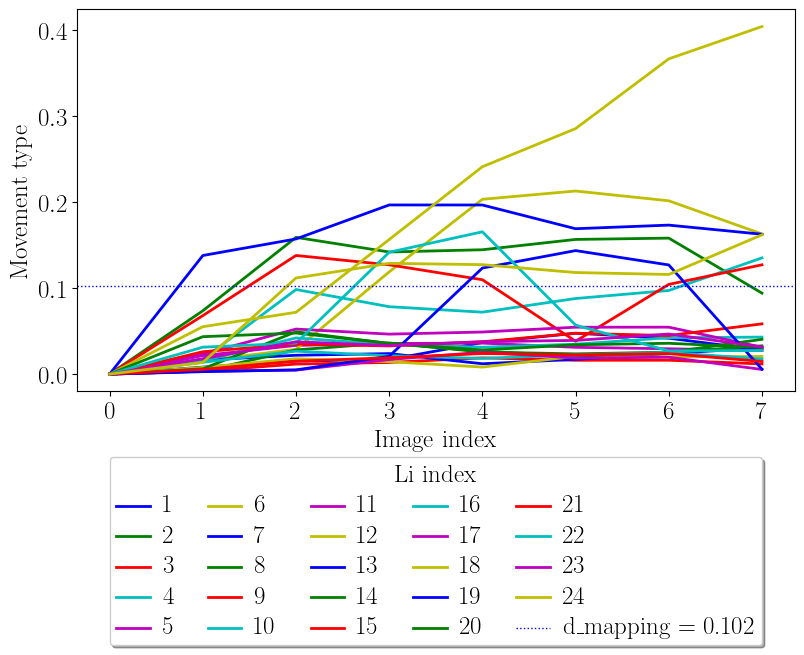

In [36]:
var_filename = "CONTCAR_positive"

if proceed_NEB=="True":
    idx_ref = 0
    idx_file_group = [0, 8]
    mean_ref = False
    df_distance, dataframe_group = move_by_distance.get_distance_li(df_mapping_metainfo, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
    movement.plot_distance(df_distance, direc_restructure_destination, max_mapping_radius, litype, 
                        activate_shiftby1_labelatom=True, activate_shifting_x = False, 
                        activate_diameter_line=True, Li_idxs="all",
                        counted_object="distance")

coor_Li_ref: [array([0.95835192, 0.31685874, 0.33103917]), array([0.99430774, 0.70141252, 0.69614921]), array([0.02858495, 0.27573254, 0.68386619]), array([0.07317737, 0.78755527, 0.07908696]), array([0.18178152, 0.19006794, 0.97419491]), array([0.34472333, 0.64878575, 0.04763612]), array([0.79589717, 0.21510678, 0.02025111]), array([0.69483125, 0.67827248, 0.96747641]), array([0.19957707, 0.98852095, 0.22489566]), array([0.32196063, 0.02614832, 0.73040604]), array([0.83198746, 0.96166074, 0.82571183]), array([0.82470757, 0.02052615, 0.21474765]), array([0.27490918, 0.80022583, 0.48200606]), array([0.32964366, 0.21528613, 0.52567716]), array([0.72751201, 0.8224285 , 0.52388656]), array([0.66606279, 0.17108496, 0.46734986]), array([0.213564  , 0.4794397 , 0.70118373]), array([0.16863312, 0.54818007, 0.32165261]), array([0.71427014, 0.48185846, 0.20961033]), array([0.789857  , 0.51568295, 0.66980573]), array([0.47820257, 0.32562985, 0.83345355]), array([0.4863265 , 0.81195002, 0.29922602

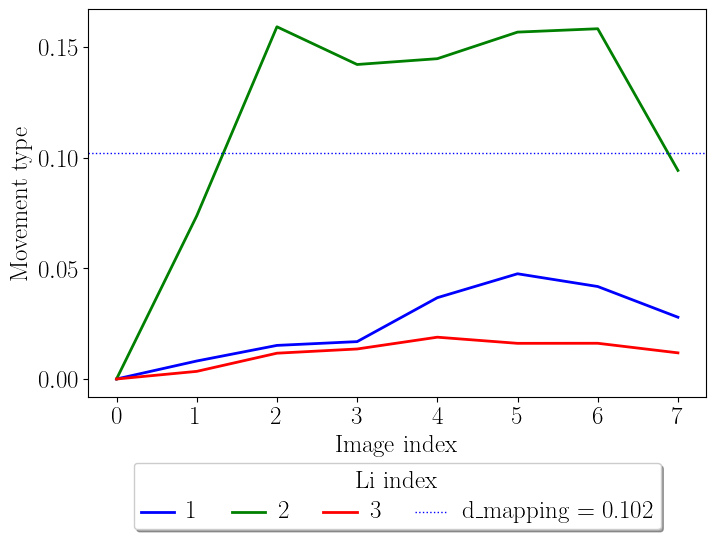

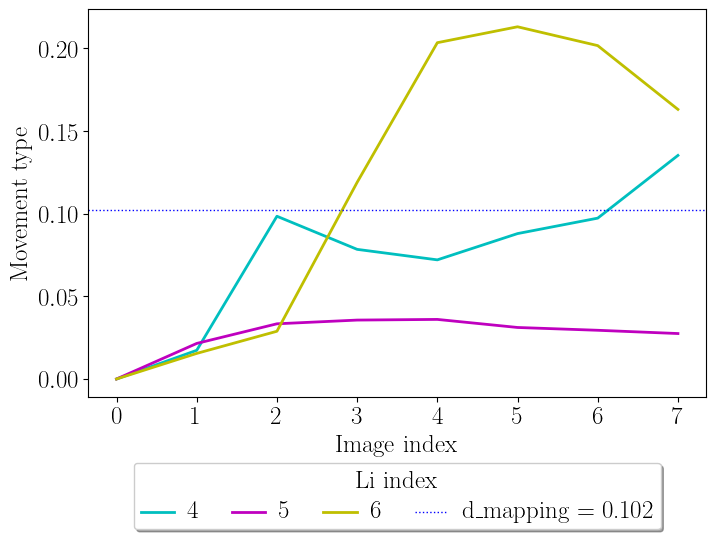

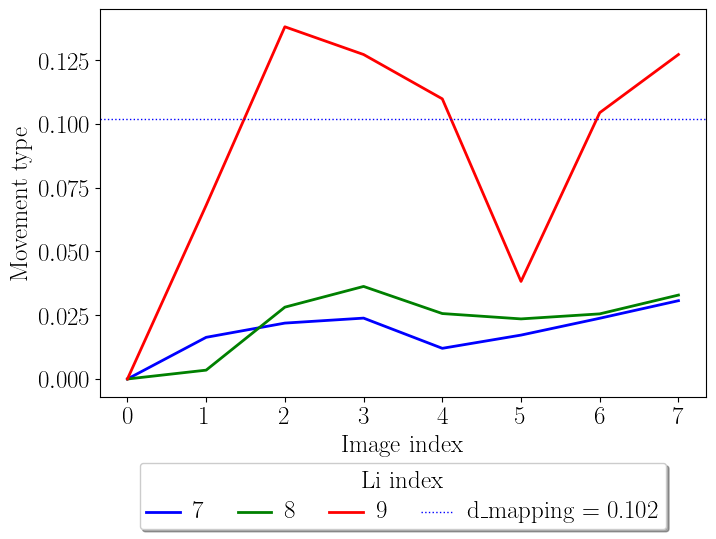

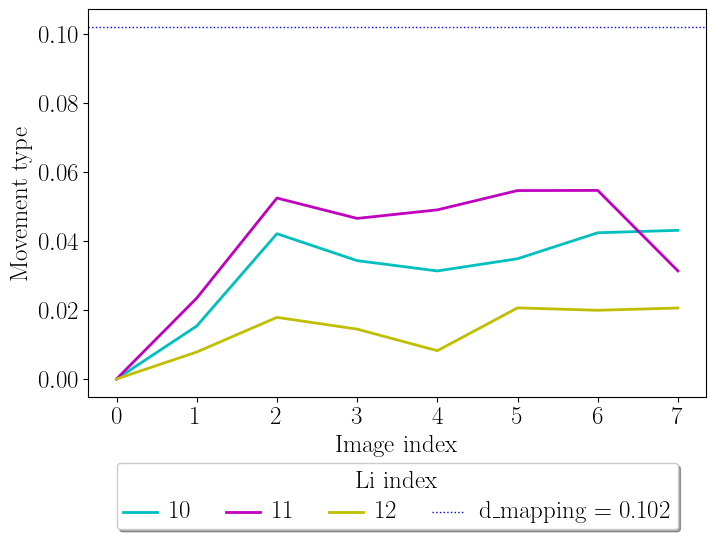

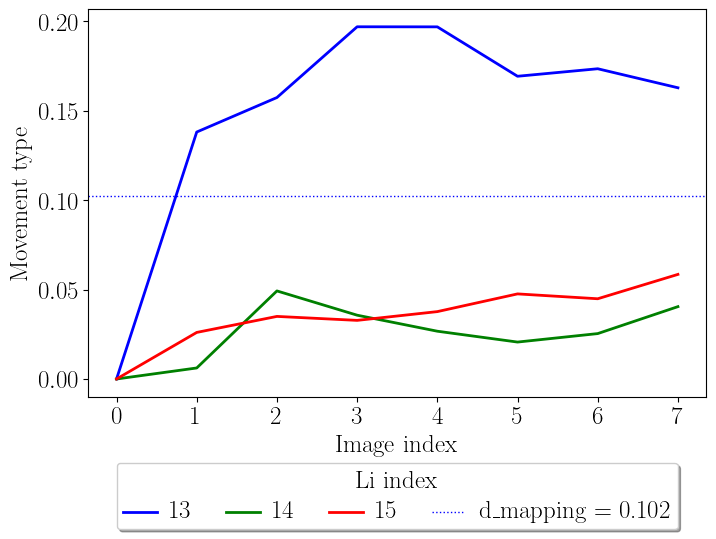

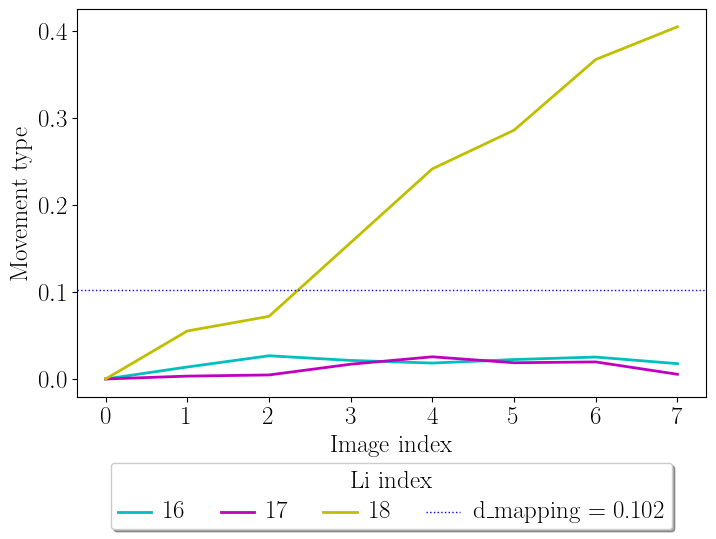

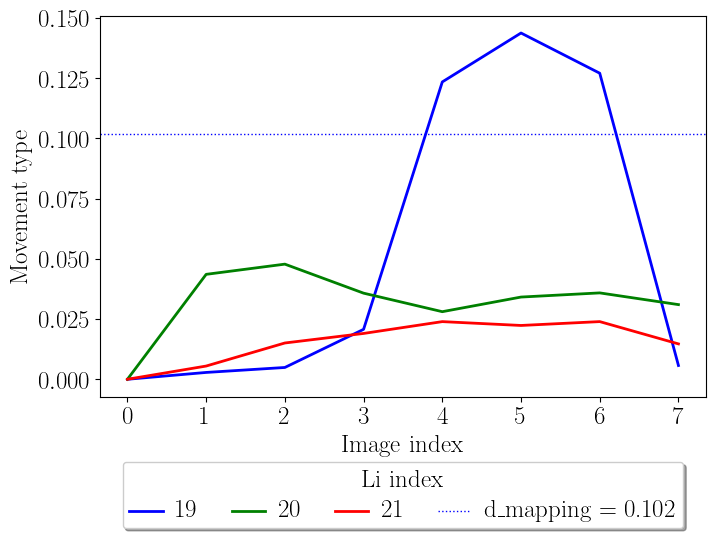

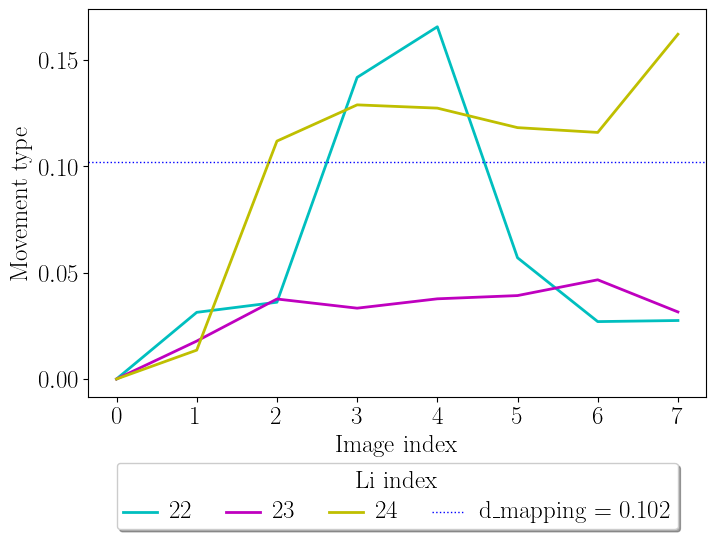

In [37]:
if proceed_NEB == "True":
    idx_ref = 0
    idx_file_group = [0, 8]
    mean_ref = False
    df_distance, dataframe_group = move_by_distance.get_distance_li(df_mapping_metainfo, max_mapping_radius, 
                                                                    direc_restructure_destination, idx_file_group, 
                                                                    idx_ref, mean_ref, var_filename)
    chunk_size = 3
    total_items = amount_Li  # Adjust this if your total number of items changes

    # Loop through the range in steps of chunk_size
    for start_idx in range(0, total_items, chunk_size):
        end_idx = start_idx + chunk_size
        Li_idxs_range = range(start_idx, end_idx)
    
        movement.plot_distance(df_distance, direc_restructure_destination, max_mapping_radius, litype, 
                            activate_shiftby1_labelatom=True, activate_shifting_x = False, 
                            activate_diameter_line=True, Li_idxs=Li_idxs_range,
                            counted_object="distance")

In [38]:
xxxxx - xxxx

NameError: name 'xxxxx' is not defined

# Intra triad

In [ ]:
var_filename = "CONTCAR_positive"

In [ ]:
# idx_ref = 0
# idx_file_group = [0, 16]
# mean_ref = False
# df_distance, dataframe_group = distance.get_distance_li(df_mapping_metainfo_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, Li_idxs="all")

# df_distance_average_rms = df_distance.copy()
# column_averages = df_distance.mean()
# df = df.append(column_averages, ignore_index=True)

# df_distance.transpose().to_excel(f'06_distance_LitoLi_intratriad_litype{litype}_{var_filename}.xlsx', index=True)

# Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=True, Li_idxs='all')

In [ ]:
# df_distance.iloc[:, :12]

In [ ]:
# df_distance.iloc[:, 12:24]

In [ ]:
df_mapping_metainfo_sorted['geometry'][2]

In [ ]:
idx_ref = 26
idx_file_group = [0, 53]
mean_ref = False

df_distance, dataframe_group = move_by_distance.get_distance_li(df_mapping_metainfo_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
movement.plot_distance(df_distance, direc_restructure_destination, max_mapping_radius, litype, 
                       activate_shifting_x = False, activate_diameter_line=True, Li_idxs="all",
                       counted_object="distance")

# # df_distance_average_rms = df_distance.copy()
# # column_averages = df_distance.mean()
# # df = df.append(column_averages, ignore_index=True)

df_distance.transpose().to_excel(f'06_test_distance_LitoLi_intracage_litype{litype}_{var_filename}_{idx_ref}.xlsx', index=True)

In [ ]:
df_distance.iloc[:, :12]

In [ ]:
df_distance.iloc[:, 12:24]

In [ ]:
idx_ref = 0
idx_file_group = [0, 16]
mean_ref = True

# # df_distance, dataframe_group = distance.get_distance_li(df_mapping_metainfo_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=True, Li_idxs="all")

# # df_distance_average_rms = df_distance.copy()
# # column_averages = df_distance.mean()
# # df = df.append(column_averages, ignore_index=True)

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intratriad_litype{litype}_{var_filename}_meanref.xlsx', index=True)

In [ ]:
# df_distance

In [ ]:
# for i in range(amount_Li):
#     Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_diameter_line=False, Li_idxs=[i])

In [ ]:
# dataframe = df_mapping_metainfo
# idx_ref = 0
# destination_directory = direc_restructure_destination
# coor_Li_ref = []

# if 'CONTCAR' in var_filename:
#     file_ref = f"{int(dataframe['geometry'][idx_ref])}_{int(dataframe['path'][idx_ref])}_{var_filename}"
# else:
#     file_ref = f"{int(dataframe['geometry'][idx_ref])}_{int(dataframe['path'][idx_ref])}_{var_filename}.cif"
# file_path_ref = os.path.join(destination_directory, file_ref)

# structure_ref = Structure.from_file(file_path_ref)

# for idx, coor in enumerate(structure_ref):
#     if coor.species_string == "Li":
#         coor_Li_ref.append(coor.frac_coords)

In [ ]:
# coor_Li_ref

In [ ]:
# coor_Li_ref_mean = np.mean(coor_Li_ref, axis=0)

In [ ]:
# coor_Li_ref_mean

In [ ]:
idx_ref = 0
idx_file_group = [0, 16]
mean_ref = False
df_distance, dataframe_group = move_by_distance.get_distance_li(df_mapping_metainfo, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
movement.plot_distance(df_distance, direc_restructure_destination, max_mapping_radius, litype, 
                       activate_shiftby1_labelatom=True, activate_shifting_x = False, 
                       activate_diameter_line=True, Li_idxs="all",
                       counted_object="distance")

In [ ]:
df_distance.iloc[:, 0:12]

In [ ]:
chunk_size = 3
total_items = amount_Li  # Adjust this if your total number of items changes

# Loop through the range in steps of chunk_size
for start_idx in range(0, total_items, chunk_size):
    end_idx = start_idx + chunk_size
    Li_idxs_range = range(start_idx, end_idx)
    
    # Call your function with the current range of Li_idxs
    movement.plot_distance(df_distance, direc_restructure_destination, max_mapping_radius, litype, 
                       activate_shiftby1_labelatom=True, activate_shifting_x = False, 
                       activate_diameter_line=True, Li_idxs="all",
                       counted_object="distance")

# Intra cage

In [ ]:
# # idx_ref = 3 # 20
# # idx_file_group = [0, 16]
# # mean_ref = False
# # df_distance, dataframe_group = get_distance_litoli(df_mapping_metainfo_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x=False, activate_diameter_line=False, Li_idxs="all")

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intracage_litype{litype}_{var_filename}.xlsx', index=True)

In [ ]:
# # idx_ref = 3 # 20
# # idx_file_group = [0, 16]
# # mean_ref = True
# # df_distance, dataframe_group = get_distance_litoli(df_mapping_metainfo_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x=False, activate_diameter_line=False, Li_idxs="all")

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intracage_litype{litype}_{var_filename}_meanref.xlsx', index=True)

In [ ]:
# for i in range(amount_Li):
#    Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_diameter_line=False, Li_idxs=[i])

In [ ]:
df_mapping_metainfo.columns

In [ ]:
df_mapping_metainfo['idx_coor_limapped_weirdos_dict'][1]

In [ ]:
df_mapping_metainfo['idx_coor_weirdos_Li'][4]

In [ ]:
df_mapping_metainfo['coor_reduced120_sorted_Li'][4]

In [ ]:
len(df_mapping_metainfo['coor_reduced120_sorted_Li'][4])

In [ ]:
df_mapping_metainfo['atom_mapping_Li_w_dist_closestduplicate'][4]

In [ ]:
len(df_mapping_metainfo['atom_mapping_Li_w_dist_closestduplicate'][4])

In [ ]:
df_mapping_metainfo['atom_mapping_Li_w_dist_label'][4]

In [ ]:
df_mapping_metainfo['idx_coor_limapped_weirdos_dict'][4]

In [ ]:
df_mapping_metainfo['idx_coor_limapped_weirdos_dict_init'][4]

In [ ]:
df_mapping_metainfo['idx_coor24li_tuple_cage_belongin_complete_closest'][4]

In [ ]:
df_mapping_metainfo['idx_coor_limapped_weirdos_dict'][4]

In [ ]:
# dataframe = df_mapping_metainfo_sorted
# el = "Li"
# idx = 0

In [ ]:
# col_top1_sorted_idxweirdo_label_el = f"top1_sorted_idxweirdo_label_{el}"

# # for idx in range(dataframe["geometry"].size):
# top1_sorted_idxweirdo_label_el = dataframe.at[idx, col_top1_sorted_idxweirdo_label_el]



In [ ]:
# data = dataframe[col_top1_sorted_idxweirdo_label_el]

In [ ]:
# data

In [ ]:
# df = pd.DataFrame(data.items(), columns=['index', 'col_name'])

# # Count empty dictionaries
# empty_count = df['col_name'].apply(lambda x: len(x) == 0).sum()

# # Count occurrences of certain types
# type_count = df['col_name'].apply(lambda x: next(iter(x.values()))[0] if x else None).value_counts()

# print(f"Number of empty dictionaries: {empty_count}")
# print(f"Occurrences of certain types:\n{type_count}")

# K-means analysis

In [ ]:
if np.array_equal(coor_weirdos_Li, np.array([])) == False:

    centroids_2, labels_2 = func_kmeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 2)
    centroids_3, labels_3 = func_kmeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 3)
    centroids_4, labels_4 = func_kmeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 4)
    centroids_5, labels_5 = func_kmeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 5)

    print(f"centroids: \n {centroids_2}")
    print(f"centroids: \n {centroids_3}")
    print(f"centroids: \n {centroids_4}")
    print(f"centroids: \n {centroids_5}")

    func_kmeans.create_POSCAR_atoms_centroids_appended(coor_weirdos_Li, centroids_2, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids2")
    func_kmeans.create_POSCAR_atoms_centroids_appended(coor_weirdos_Li, centroids_3, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids3")
    func_kmeans.create_POSCAR_atoms_centroids_appended(coor_weirdos_Li, centroids_4, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids4")

    structure_analysis.plot_distweirdos(df_mapping_metainfo)

# visualization of mapped atom

In [ ]:
df = mapping_labelling.plot_mapped_label_vs_dist_and_histogram(df_mapping_metainfo, litype, category_data = "mapping", el = "Li")

In [ ]:
# df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_weirdos_Li","sum_weirdos_48htype2_Li","dist_weirdos_atom"dist_weirdos_48htype2_atom72_Li","idx1_weirdos_Li","#weirdos_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
if activate_radius == 3:
    df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype1_48htype2_Li_closestduplicate","sum_weirdos_48htype1_48htype2_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
    df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype1_48htype2_Li_closestduplicate","sum_weirdos_48htype1_48htype2_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]]
    
    sum_weirdos_Li = float(df_mapping_metainfo_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}"

elif activate_radius == 2:
    if litype == 2:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 3:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 4:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 5:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 6:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 7:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 8:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]]   

    sum_weirdos_Li = float(df_mapping_metainfo_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}"

elif activate_radius == 1:
    if litype == 2:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 3:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 4:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 5:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 6:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 7:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 8:
        df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]]   

    sum_weirdos_Li = float(df_mapping_metainfo_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}"

In [ ]:
df = mapping_labelling.plot_mapped_label_vs_dist_and_histogram(df_mapping_metainfo, litype, category_data = "mapping", el = "Li")

df_48htype2 = df.loc[df['label'] == '48htype2']

fig = px.scatter(df_48htype2, 
                x = 'idx_nr', 
                y = 'dist',
                title = 'Distance of mapped 48htype2 vs its file index nr'
                )

fig.show(config={'scrollZoom': True})

# find radius that removes all weirdos in the first groups

## all weirdos

In [ ]:
df = mapping_labelling.plot_mapped_label_vs_dist_and_histogram(df_mapping_metainfo, litype, category_data = "weirdo", el = "Li")

fig = px.scatter(df, 
                x = 'idx_nr', 
                y = 'dist',
                # mode = "markers"
                color = 'label',
                title = 'Distance of weirdos vs its file index nr (0: lowest energy)',
                hover_data = ['dist', 'label', 'idx_nr', 'coor']
                )

fig.show(config={'scrollZoom': True}) 

# weirdos of 0:17

In [ ]:
df = mapping_labelling.plot_mapped_label_vs_dist_and_histogram(df_mapping_metainfo[:17], litype, category_data = "weirdo", el = "Li")

fig = px.scatter(df, 
                x = 'idx_nr', 
                y = 'dist',
                # mode = "markers"
                color = 'label',
                title = 'Distance of weirdos vs its file index nr'
                )

fig.show(config={'scrollZoom': True})

In [ ]:
df_mapping_metainfo_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}_sorted.xlsx', index=False)
df_mapping_metainfo_not_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}.xlsx', index=False)

In [ ]:
if activate_radius == 1:
    df_mapping_metainfo.to_pickle(f'df_mapping_metainfo_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}.pkl') 
elif activate_radius == 2:
    df_mapping_metainfo.to_pickle(f'df_mapping_metainfo_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}.pkl')
elif activate_radius == 3:
    df_mapping_metainfo.to_pickle(f'df_mapping_metainfo_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}.pkl')

In [ ]:
df_mapping_metainfo.columns

In [ ]:
df_mapping_metainfo['atom_mapping_Li_w_dist_label'][1]

In [ ]:
df_mapping_metainfo_sorted_complete = df_mapping_metainfo.sort_values("toten [eV]", ascending=True).reset_index()

In [ ]:
df_mapping_metainfo_sorted_complete

In [ ]:
df_mapping_metainfo_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][26]

In [ ]:
df_mapping_metainfo_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][11]

In [ ]:
df_mapping_metainfo_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][20]

In [ ]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=FutureWarning)

In [ ]:
dataframe = df_mapping_metainfo_sorted_complete

col_idx_coor24li_tuple_cage_belongin_complete_id48htype2 = 'idx_coor24li_tuple_cage_belongin_complete_id48htype2'

col_idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = "idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    for idx in range(dataframe["geometry"].size):

        # idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = defaultdict(list)

        idx_coor24li_tuple_cage_belongin_complete_id48htype2 = dataframe[col_idx_coor24li_tuple_cage_belongin_complete_id48htype2][idx]

        # Filtered dictionary
        idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = {key: value for key, value in idx_coor24li_tuple_cage_belongin_complete_id48htype2.items() if value['type'] in ['weirdos', '48htype1']}

        # # Check if filtered dictionary is empty, if so, set it to {}
        # if not idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered:
        #     idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = {}

        print(idx)
        print(idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered)

        dataframe.at[idx, col_idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered] = idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered

        # # Iterate through each key, value pair in the dictionary
        # for key, value in idx_coor24li_tuple_cage_belongin_complete_id48htype2.items():
        #     # Check if the 'type' is 'weirdos' or '48htype4'
        #     if value['type'] in ['weirdos', '48htype4']:
        #         # Print the key and value
        #         print(f"Key: {key}, Value: {value}")

In [ ]:
{key: value for key, value in df_mapping_metainfo_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][42].items() if value['type'] in ['weirdos', '48htype1']}

In [ ]:
coor_48htype1_metainfo

In [ ]:
idx_cage_dict = {key: value['idx_cage'] for key, value in df_mapping_metainfo['idx_coor24li_tuple_cage_belongin_complete_closest'][0].items()}
print(idx_cage_dict)


In [ ]:
idx_cage_dict = {key: value['idx_cage'] for key, value in df_mapping_metainfo['idx_coor24li_tuple_cage_belongin_complete_closest'][8].items()}
print(idx_cage_dict)


In [ ]:
different_idx_cage = {
    key: value['idx_cage']
    for key, value in df_mapping_metainfo['idx_coor24li_tuple_cage_belongin_complete_closest'][8].items()
    if value['idx_cage'] != df_mapping_metainfo['idx_coor24li_tuple_cage_belongin_complete_closest'][0][key]['idx_cage']
}

print(different_idx_cage)


In [ ]:
func_distance.mic_eucledian_distance([0.66882, 0.47147, 0.16882], [0.33118, 0.52853, 0.16882])

In [ ]:
func_distance.mic_eucledian_distance([0.97111, 0.25000, 0.25000], [0.97147, 0.33118, 0.33118])

In [ ]:
func_distance.mic_eucledian_distance([0.75000, 0.25000, 0.25000], [0.25000, 0.75000, 0.25000])

In [ ]:
func_distance.mic_eucledian_distance([0.79503, 0.43060, 0.43057], [0.93057, 0.70497, 0.56940])

In [ ]:
func_distance.mic_eucledian_distance([0.06943, 0.79503, 0.06940], [0.97111, 0.75000, 0.75000])

In [ ]:
df_mapping_metainfo['idx_coor24li_tuple_cage_belongin_complete_closest'][0]

In [ ]:
xxxx - xx

# Optimize dx_dz of 48htype1, r_2 for files w/o weirdos

In [ ]:
df_wo_weirdos_selectedcol = df_mapping_metainfo[['geometry','path','subdir_new_system', 'toten [eV]']].sort_values("toten [eV]", ascending=True)[0:17].reset_index().copy()

In [ ]:
df_wo_weirdos_selectedcol

In [ ]:
if activate_radius == 3:
    folder_name_destination_restructure_wo_weirdos = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}_wo_weirdos/"
elif activate_radius == 2:
    folder_name_destination_restructure_wo_weirdos = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}_wo_weirdos/"
elif activate_radius == 1:
    folder_name_destination_restructure_wo_weirdos = f"/restructure_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}_wo_weirdos/"
else:
    print("activate_radius is not correct")

direc_restructure_destination_wo_weirdos = direc+str(folder_name_destination_restructure_wo_weirdos)

In [ ]:
# just refreshing folder
func_directory.check_folder_existance(direc_restructure_destination_wo_weirdos, empty_folder=True)

# # # # # # just copy file
# # # # # Operation.File.copy_rename_single_file(direc_restructure_destination_wo_weirdos, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)
# # # # # Operation.File.copy_rename_single_file(direc_restructure_destination_wo_weirdos, direc_perfect_poscar, file_perfect_poscar_48n24, prefix=None)

# # # # # Operation.File.copy_rename_files(df_wo_weirdos_selectedcol, direc_restructure_destination_wo_weirdos, file_restructure, prefix=None, savedir = True)

In [ ]:
coor_ref_structure_48n24 = coordinate_and_el.single_structure(ref_structure_48n24)

CONTCARorPOSCAR.positive_lessthan1(df_wo_weirdos_selectedcol, direc_restructure_destination_wo_weirdos, poscar_line_nr_start, poscar_line_nr_end, contcar_columns_type2, file_type = "CONTCAR", var_name_in = None, var_name_out = "positive", n_decimal=16)
coordinate_and_el.structures(df_wo_weirdos_selectedcol, mapping = "False")

if activate_radius == 3:
    flag_and_map.all_atoms_of_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius)
    flag_and_map.li_48htype1_48htype2(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype1_48htype2)
    flag_and_map.li_48htypesmerged_level1(df_wo_weirdos_selectedcol, "Li")
    flag_and_map.li_48htype2(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    flag_and_map.li_48htypesmerged(df_wo_weirdos_selectedcol, "Li", activate_radius)
elif activate_radius == 2:
    flag_and_map.all_atoms_of_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius)
    flag_and_map.li_48htype2(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    flag_and_map.li_48htypesmerged(df_wo_weirdos_selectedcol, "Li", activate_radius)
elif activate_radius == 1:
    flag_and_map.all_atoms_of_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius)

# flag_and_map.all_atoms_of_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "P", max_mapping_radius)
# flag_and_map.all_atoms_of_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "S", max_mapping_radius)
# flag_and_map.all_atoms_of_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Cl", max_mapping_radius)

In [ ]:
xxx - xxxx

In [ ]:
dataframe = df_mapping_metainfo

col_top1_sorted_idxweirdo_dist_el = "top1_sorted_idxweirdo_dist_Li"
col_top1_sorted_idxweirdo_label_el = "top1_sorted_idxweirdo_label_Li"
col_top1_sorted_idxweirdo_coor_el = "top1_sorted_idxweirdo_coor_Li"
col_top1_sorted_idxweirdo_file_el = "top1_sorted_idxweirdo_file_Li"

val = 0.

dist_weirdos_el_appendend = []
y_appended = []
label_weirdos_el_appended = []
coor_weirdos_el_appended = []
file_weirdos_el_appended = []

for idx in range(dataframe["geometry"].size):
    dist_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_dist_el].values()
    label_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_label_el].values()
    coor_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_coor_el].values()
    file_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_file_el].values()

    for single_dist in dist_weirdos_el:
        dist_weirdos_el_appendend.append(single_dist[0])
        y_appended.append(np.zeros_like(single_dist[0]) + val)

    for single_label in label_weirdos_el:
        label_weirdos_el_appended.append(single_label[0])

    for single_coor in coor_weirdos_el:
        coor_weirdos_el_appended.append(single_coor[0])
    
    for single_file in file_weirdos_el:
        file_weirdos_el_appended.append(single_file[0])

df = pd.DataFrame({'dist': dist_weirdos_el_appendend, 'label': label_weirdos_el_appended, 'y': y_appended, 'coor': coor_weirdos_el_appended, 'file': file_weirdos_el_appended})

# fig = px.scatter(df, x = 'dist', y = 'y', color='label', color_discrete_map={'48htype1': 'red', '48htype2': 'blue', '24g': 'green'})
fig = px.scatter(df, 
                 x = 'dist', 
                 y = 'y', 
                 color ='label', 
                 hover_data = ['dist', 'label', 'coor', 'file'])


fig.show(config={'scrollZoom': True})

In [ ]:
0.04718813922672343

In [ ]:
# from sklearn.cluster import MeanShift, estimate_bandwidth

# x = [1,1,5,6,1,5,10,22,23,23,50,51,51,52,100,112,130,500,512,600,12000,12230]

# X = np.array(list(zip(x,np.zeros(len(x)))), dtype='int')
# bandwidth = estimate_bandwidth(X, quantile=0.1)
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(X)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# for k in range(n_clusters_):
#     my_members = labels == k
#     print("cluster {0}: {1}".format(k, X[my_members, 0]))

In [ ]:
# DBSCAN
# source: https://stackoverflow.com/questions/11513484/1d-number-array-clustering

# points = [0.1, 0.31,  0.32, 0.45, 0.35, 0.40, 0.5 ]
points = dist_weirdos_el_appendend

clusters = []
# eps = 0.2
eps = 0.043
points_sorted = sorted(points)
curr_point = points_sorted[0]
curr_cluster = [curr_point]
for point in points_sorted[1:]:
    if point <= curr_point + eps:
        curr_cluster.append(point)
    else:
        clusters.append(curr_cluster)
        curr_cluster = [point]
    curr_point = point
clusters.append(curr_cluster)
print(clusters)

In [ ]:
for i in clusters:
    print(i)

In [ ]:
clusters[0][int(len(clusters[0])/2)]

In [ ]:
len(clusters[0])

In [ ]:
len(clusters)

## another idea: plot based on litype

In [ ]:
# from sklearn.datasets import make_swiss_roll

# X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
        # # source: https://plotly.com/python/v3/3d-point-clustering/
        # scatter = dict(
        #     mode = "markers",
        #     name = "y",
        #     type = "scatter3d",
        #     x = coordinates[0], y = coordinates[1], z = coordinates[2],
        #     # x = tuple(coordinates[0]), y = tuple(coordinates[1]), z = tuple(coordinates[2]),
        #     marker = dict( size=2, color="rgb(23, 190, 207)" )
        # )

        # clusters = dict(
        #     alphahull = 7,
        #     name = "y",
        #     opacity = 0.1,
        #     type = "mesh3d",
        #     x = coordinates[0], y = coordinates[1], z = coordinates[2]
        # )

        # layout = dict(
        #     title = '3d point clustering',
        #     scene = dict(
        #         xaxis = dict( zeroline=False ),
        #         yaxis = dict( zeroline=False ),
        #         zaxis = dict( zeroline=False ),
        #     )
        # )

        # fig = dict( data=[scatter, clusters], layout=layout )

        # # Use py.iplot() for IPython notebook
        # pyoff.iplot(fig, filename='3d point clustering')

        # scatter = go.Scatter3d(
        #     mode="markers",
        #     name="y",
        #     x=coordinates[0],
        #     y=coordinates[1],
        #     z=coordinates[2],
        #     marker=dict(size=2, color="rgb(23, 190, 207)")
        # )

        # clusters = go.Mesh3d(
        #     alphahull=7,
        #     name="y",
        #     opacity=0.1,
        #     x=coordinates[0],
        #     y=coordinates[1],
        #     z=coordinates[2]
        # )

        # layout = go.Layout(
        #     title='3d point clustering',
        #     scene=dict(
        #         xaxis=dict(zeroline=False),
        #         yaxis=dict(zeroline=False),
        #         zaxis=dict(zeroline=False),
        #     )
        # )

        # fig = go.Figure(data=[scatter, clusters], layout=layout)

        # # Use iplot() for offline plotting
        # # iplot(fig, filename='3d point clustering')
        # pyoff(fig, filename='3d point clustering')

In [ ]:
CONTCARorPOSCAR.get_latticeconstant_dict(df_mapping_metainfo, direc_restructure_destination, var_filename = "trf_w_linalg_orientated_positive_lessthan1")
func_cartesian.Cartesian.get_fractional_to_cartesian_matrix(df_mapping_metainfo, var_filename = "trf_w_linalg_orientated_positive_lessthan1", angle_in_degrees=True)
func_cartesian.Cartesian.get_fractional_to_cartesian_coor(df_mapping_metainfo, direc_restructure_destination, var_filename = "trf_w_linalg_orientated_positive_lessthan1")

In [ ]:
max_neighbors_radius = 5
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "Li", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "P", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "S", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "Cl", var_filename = "trf_w_linalg_orientated_positive_lessthan1")

In [ ]:
# df_mapping_metainfo["distance_cartesian_trf_w_linalg_orientated_positive_S"][45]

In [ ]:
# my_dict = df_mapping_metainfo["distance_cartesian_trf_w_linalg_orientated_positive_Li"][45]

# max_length = max(len(lst) for lst in my_dict.values())

# # Fill in missing values with None to make all lists the same length
# for key in my_dict:
#     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # Create a DataFrame from the modified dictionary
# df_my_dict = pd.DataFrame(my_dict)

# df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# df_my_dict = df_my_dict.sort_index(axis=1)
# df_my_dict = df_my_dict.transpose()
# # Save the DataFrame to an Excel file without the index
# df_my_dict.to_excel('neighbors_Li_trf_w_linalg_orientated_positive_45.xlsx', index=True)

In [ ]:
CONTCARorPOSCAR.get_latticeconstant_dict(df_mapping_metainfo, direc_restructure_destination, var_filename = "CONTCAR")
func_cartesian.Cartesian.get_fractional_to_cartesian_matrix(df_mapping_metainfo, var_filename = "CONTCAR", angle_in_degrees=True)
func_cartesian.Cartesian.get_fractional_to_cartesian_coor(df_mapping_metainfo, direc_restructure_destination, var_filename = "CONTCAR")

In [ ]:
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "Li", var_filename = "CONTCAR")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "P", var_filename = "CONTCAR")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "S", var_filename = "CONTCAR")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "Cl", var_filename = "CONTCAR")

In [ ]:
# # # df_mapping_metainfo["distance_cartesian_CONTCAR_S"][45]

In [ ]:
# # # my_dict = df_mapping_metainfo["distance_cartesian_CONTCAR_Li"][45]

# # # max_length = max(len(lst) for lst in my_dict.values())

# # # # Fill in missing values with None to make all lists the same length
# # # for key in my_dict:
# # #     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # # # Create a DataFrame from the modified dictionary
# # # df_my_dict = pd.DataFrame(my_dict)

# # # df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# # # df_my_dict = df_my_dict.sort_index(axis=1)
# # # df_my_dict = df_my_dict.transpose()
# # # # Save the DataFrame to an Excel file without the index
# # # df_my_dict.to_excel(f'neighbors_Li_CONTCAR_45_{max_mapping_radius}.xlsx', index=True)

In [ ]:
CONTCARorPOSCAR.get_latticeconstant_structure_dict_iterated(df_mapping_metainfo, direc_restructure_destination, var_filename = "trf_w_linalg_orientated")
func_cartesian.Cartesian.get_fractional_to_cartesian_matrix(df_mapping_metainfo, var_filename = "trf_w_linalg_orientated", angle_in_degrees=True)
func_cartesian.Cartesian.get_fractional_to_cartesian_coor(df_mapping_metainfo, direc_restructure_destination, var_filename = "trf_w_linalg_orientated")

In [ ]:
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "Li", var_filename = "trf_w_linalg_orientated")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "P", var_filename = "trf_w_linalg_orientated")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "S", var_filename = "trf_w_linalg_orientated")
func_cartesian.Cartesian.get_closest_neighbors_el_cartesian_coor(df_mapping_metainfo, max_neighbors_radius, el = "Cl", var_filename = "trf_w_linalg_orientated")

In [ ]:
# # # my_dict = df_mapping_metainfo["distance_cartesian_trf_w_linalg_orientated_Li"][45]

# # # max_length = max(len(lst) for lst in my_dict.values())

# # # # Fill in missing values with None to make all lists the same length
# # # for key in my_dict:
# # #     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # # # Create a DataFrame from the modified dictionary
# # # df_my_dict = pd.DataFrame(my_dict)

# # # df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# # # df_my_dict = df_my_dict.sort_index(axis=1)
# # # df_my_dict = df_my_dict.transpose()
# # # # Save the DataFrame to an Excel file without the index
# # # df_my_dict.to_excel(f'neighbors_Li_trf_w_linalg_orientated_45_{max_mapping_radius}.xlsx', index=True)

In [ ]:
# df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","dist_weirdos_atom72_Li","idx1_weirdos_Li","#weirdos_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
df_mapping_metainfo_sorted_toten = df_mapping_metainfo[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","idx0_weirdos_Li","sum_weirdos_Li","sum_mapped_Li_new","sum_sanitycheck_Li_new","duplicate_closest24_w_data_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
df_mapping_metainfo_not_sorted_toten = df_mapping_metainfo[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","idx0_weirdos_Li","sum_weirdos_Li","sum_mapped_Li_new","sum_sanitycheck_Li_new","duplicate_closest24_w_data_Li","toten [eV]"]]

df_mapping_metainfo_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}_sorted.xlsx', index=False)
df_mapping_metainfo_not_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}.xlsx', index=False)

In [ ]:
df_mapping_metainfo['scaling'][48]

In [ ]:
df_mapping_metainfo['translation'][48]

In [ ]:
lattice_constants_1_0 = [[10.0222501477270232, -0.0006786050655888, -0.0018947275007341], [-0.0006784775666570, 10.0236290992971000, 0.0006784775666570], [-0.0018947275007341, 0.0006786050655888, 10.0222501477270232]]

In [ ]:
np.dot(lattice_constants_1_0, df_mapping_metainfo['scaling'][48].T)

In [ ]:
new_lattice_constant_1_0 = np.round(np.dot(lattice_constants_1_0, df_mapping_metainfo['scaling'][48].T) + df_mapping_metainfo['translation'][48], decimals=16)

In [ ]:
np.savetxt('new_constants_trial', new_lattice_constant_1_0)

In [ ]:
-0.11331824 + 1.89472750e-03

In [ ]:
1.00236291e+01 + 0.2500525

In [ ]:
-6.78477567e-04 + 0.38668173

In [ ]:
new_lattice_constant_1_0_precision = np.round(new_lattice_constant_1_0, decimals=16)

In [ ]:
new_lattice_constant_1_0_precision

In [ ]:
direc_restructure_destination

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_pymatgen.cif').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_trf_w_lib.cif').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_trf_w_linalg.cif').lattice

In [ ]:
new_lattice_constant_1_0_nottransposed = np.round(np.dot(lattice_constants_1_0, df_mapping_metainfo['scaling'][48]) + df_mapping_metainfo['translation'][48], decimals=16)

In [ ]:
np.savetxt('new_constants_trial_not_transposed', new_lattice_constant_1_0_nottransposed)

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_edit').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_edit_not_transposed').lattice